<a href="https://colab.research.google.com/github/Totti00/VA_Project/blob/develop/VA_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First commit

In [ ]:
!wget https://www.dropbox.com/scl/fi/ybx2y1kvy99e2240gc9gg/san-vitale-challenge-dataset.zip?rlkey=kaye183spvmgyqx378rehrzjn&dl=0
!unzip -q san-vitale-challenge-dataset.zip?rlkey=kaye183spvmgyqx378rehrzjn
!rm san-vitale-challenge-dataset.zip?rlkey=kaye183spvmgyqx378rehrzjn

In [ ]:
!pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'
!pip install uvicorn
!pip install python-multipart
!pip install kaleido
!pip install fastapi
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision

In [2]:
import os
from PIL import Image
import math
import json
import torch
from timeit import default_timer as timer
from datetime import timedelta
import cv2
from matplotlib import pyplot as plt
import numpy as np
from google.colab.patches import cv2_imshow
from scipy.spatial.distance import directed_hausdorff
#from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
#import supervision as sv
from sklearn.decomposition import PCA

def resize_img(img_path, input_size):
  my_image = plt.imread(img_path)
  print(my_image.shape)
  if max(my_image.shape[0], my_image.shape[1]) > input_size:
    if my_image.shape[0] >= my_image.shape[1]:
      height = input_size
      width = int(my_image.shape[1] * input_size / my_image.shape[0])
    else:
      width = input_size
      height = int(my_image.shape[0] * input_size / my_image.shape[1])
    my_image = cv2.resize(my_image, (width, height), interpolation=cv2.INTER_LINEAR)
  plt.imsave(img_path, my_image)

def pad_img(img_path, input_size):
  my_image = plt.imread(img_path)
  pad_width = input_size - my_image.shape[0]
  pad_height = input_size - my_image.shape[1]
  my_padded_image = np.pad(my_image, ((0, pad_width), (0, pad_height), (0, 0)), 'constant')
  plt.imsave(img_path, my_padded_image)

def crop_image(image):
  cropped_image = image[1000:, 1500:]
  cropped_image = cropped_image[:2400, :2600]
  return cropped_image

def sliding_window_hausdorff_distance(contoursA, contoursB, window_size):
  min_distance = float('inf')

  # Confronta l'array più piccolo con una porzione dell'array più grande
  for i in range(len(contoursB) - window_size + 1):
    window_contoursB = contoursB[i:i+window_size]

    # Calcola la distanza di Hausdorff diretta tra i contorni
    distance= directed_hausdorff(contoursA, window_contoursB)[0]

    # Aggiorna la minima distanza se necessario
    min_distance = min(min_distance, distance)

    # Ripeti il confronto con finestre di dimensioni ridotte
    for window_size in range(window_size - 1, 0, -1):
      for i in range(len(contoursB) - window_size + 1):
        window_contoursB = contoursB[i:i+window_size]

        # Calcola la distanza di Hausdorff diretta tra i contorni
        distance= directed_hausdorff(contoursA, window_contoursB)[0]

        # Aggiorna la minima distanza se necessario
        min_distance = min(min_distance, distance)

  return min_distance

def find_start(img):
  for x, line in enumerate(img):
    for y, col in enumerate(line):
      if col == 255:
        return (x, y)

def check_around(img, last, edge):
  for i in range(-1, 2, 1):
    for j in range(1, -2, -1):
      x = max(0, min(last[0]+i, img.shape[0]-1))
      y = max(0, min(last[1]+j, img.shape[1]-1))
      if img[x][y] == 255 and [x, y] not in edge.tolist():
        return [x, y]
  return -1

def manhattan_check_around(img, last, edge):
  # Check up, down, left, and right directions
  for i in range(-1, 2, 2):
      x = max(0, min(last[0] + i, img.shape[0] - 1))
      y = last[1]
      if img[x][y] == 255 and [x, y] not in edge.tolist():
          return [x, y]

  for j in range(-1, 2, 2):
      x = last[0]
      y = max(0, min(last[1] + j, img.shape[1] - 1))
      if img[x][y] == 255 and [x, y] not in edge.tolist():
          return [x, y]

  # Check diagonals
  for i in range(-1, 2, 2):
      for j in range(-1, 2, 2):
          x = max(0, min(last[0] + i, img.shape[0] - 1))
          y = max(0, min(last[1] + j, img.shape[1] - 1))
          if img[x][y] == 255 and [x, y] not in edge.tolist():
              return [x, y]

  return -1

def drow_edge(img, start):
  edge = np.array([[start[0], start[1]]])
  for i in range(-1, 2, 1):
    for j in range(1, -2, -1):
      x = max(0, min(start[0]+i, img.shape[0]-1))
      y = max(0, min(start[1]+j, img.shape[1]-1))
      if img[x][y] == 255 and [x, y] not in edge.tolist():
        last = [x, y]
        edge = np.vstack((edge, last))
  while last != start:
    last = check_around(img, last, edge)
    if last == -1:
      last = check_around(img, edge[-2], edge)
      if last == -1:
        return edge
    else:
      edge = np.vstack((edge, [last[0], last[1]]))
  return edge

def manhattan_drow_edge(img, start):
  edge = np.array([[start[0], start[1]]])
  last = manhattan_check_around(img, start, edge)
  edge = np.vstack((edge, [last[0], last[1]]))
  while last != start:
    last = manhattan_check_around(img, last, edge)
    if last == -1:
      last = manhattan_check_around(img, edge[-2], edge)
      if last == -1:
        return edge
    else:
      edge = np.vstack((edge, [last[0], last[1]]))
  return edge

# Questo codice qui sotto controlla tutta la directory 6 e per ogni immagine calcola SAM e canny.
## Questo produce anche un array (array_contours) che contiene tutti gli array  dei bordi di tutte le immagini

In [ ]:
#Serve per inizializzare il tutto
HOME = os.getcwd()
print("HOME:", HOME)

!mkdir -p {HOME}/weights
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P {HOME}/weights

CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

MODEL_TYPE = "vit_h"

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device="cuda")
mask_generator = SamAutomaticMaskGenerator(sam, points_per_batch=8)

In [ ]:
folder_path = "/content/dataset/train/6"

# Elenco dei file nella cartella
file_list = os.listdir(folder_path)

#Array contenente gli array dei bordi di tutte le immagini
array_contours = []

# Apri tutte le immagini con OpenCV
images = []
for file_name in file_list:
  if file_name.endswith(('.png', '.jpg', '.jpeg')) and not file_name.startswith('gt') :
    nome_file = file_name.split('.')[0]
    file_path = os.path.join(folder_path, file_name)
    image = cv2.imread(file_path)
    img = crop_image(image)
    image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    sam_result = mask_generator.generate(image_rgb)
    masks = [mask['segmentation'] for mask in sorted(sam_result, key=lambda x: x['area'], reverse=True)]

    img = masks[1].astype('uint8') * 255 #serve per mapparla da booleano a scala di grigi
    blurred = cv2.GaussianBlur(img, (13, 13), 0)
    edges_D = cv2.Canny(blurred,0,100)
    prova = drow_edge(edges_D, find_start(edges_D))
    array_contours.append(prova)
    seg_edge = np.zeros((4016, 6016))
    x_coords, y_coords = prova[:, 0], prova[:, 1]
    seg_edge[x_coords, y_coords] = 255

    plt.imsave(os.path.join('dataset', 'train', '6', f'{nome_file}_sam_canny.png'), seg_edge)

In [ ]:
# SALVARE SU FILE

array_list = [arr.tolist() for arr in array_contours]
with open('contours.json', 'w') as f:
  json.dump(array_list, f)

In [3]:
# IMPORTARE DA FILE
with open('contours.json', 'r') as f:
  array_list = json.load(f)

contours = [np.array(arr) for arr in array_list]

In [ ]:

#QUESTO SERVE PER PLOTTARE LA FOTO SEGMENTATA MA NON SERVE FARLO
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections.from_sam(sam_result=sam_result)

annotated_image = mask_annotator.annotate(scene=img.copy(), detections=detections)

sv.plot_images_grid(
    images=[img, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

In [ ]:
#QUESTO SERVE PER PLOTTARE LE MASCHERE MA NON SERVE FARLO
masks = [mask['segmentation'] for mask
    in sorted(sam_result, key=lambda x: x['area'], reverse=True)
]

sv.plot_images_grid(
    images=masks,
    grid_size=(8, int(len(masks) / 2)),
    size=(16, 16)
)

In [ ]:
img_A = cv2.imread('/content/dataset/train/6/A.png', cv2.IMREAD_GRAYSCALE)
img_D = cv2.imread('/content/dataset/train/6/D.png', cv2.IMREAD_GRAYSCALE)

_, bwA = cv2.threshold(img_A, 140, 255, cv2.THRESH_BINARY)
_, bwD = cv2.threshold(img_D, 140, 255, cv2.THRESH_BINARY)
s = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9,9))

res1 = cv2.morphologyEx(bwA, cv2.MORPH_OPEN, s)
img_final_A = cv2.morphologyEx(res1, cv2.MORPH_CLOSE, s)
img_final_A = cv2.dilate(img_final_A, s)
cv2_imshow(img_final_A)

res1 = cv2.morphologyEx(bwD, cv2.MORPH_OPEN, s)
img_final_D = cv2.morphologyEx(res1, cv2.MORPH_CLOSE, s)
img_final_D = cv2.dilate(img_final_D, s)
cv2_imshow(img_final_D)

#res = img.copy()
#res[res2==0]=0

blurred = cv2.GaussianBlur(img_final_A, (13, 13), 0)
assert img_A is not None, "file could not be read, check with os.path.exists()"
edges_A = cv2.Canny(blurred,0,100)

blurred = cv2.GaussianBlur(img_D, (13, 13), 0)
assert img_D is not None, "file could not be read, check with os.path.exists()"
edges_D = cv2.Canny(blurred,0,100)

cropped_image_D = crop_image(edges_D)
cropped_image_A = crop_image(edges_A)
# Display cropped image
cv2_imshow(cropped_image_A)
cv2_imshow(cropped_image_D)

# Test

In [ ]:
test_segment1 = np.array([[  0, 255, 255, 255,   0,   0,   0],
                          [  0,   0,   0, 255,   0,   0,   0],
                          [  0,   0,   0, 255,   0,   0,   0],
                          [  0,   0,   0, 255,   0,   0,   0],
                          [  0,   0,   0,   0,   0,   0,   0],
                          [  0,   0,   0,   0,   0,   0,   0],
                          [  0,   0,   0,   0,   0,   0,   0]])

test_segment2 = np.array([[  0,   0,   0,   0,   0,   0,   0],
                          [  0,   0,   0,   0,   0, 255,   0],
                          [  0,   0,   0,   0,   0, 255,   0],
                          [  0,   0, 255, 255, 255, 255,   0],
                          [  0,   0,   0,   0,   0,   0,   0],
                          [  0,   0,   0,   0,   0,   0,   0],
                          [  0,   0,   0,   0,   0,   0,   0]])

test_segment3 = np.array([[  0, 255, 255, 255, 255, 255, 255],
                          [  0,   0,   0,   0,   0,   0,   0],
                          [  0,   0,   0,   0,   0,   0,   0],
                          [  0,   0,   0,   0,   0,   0,   0],
                          [  0,   0,   0,   0,   0,   0,   0],
                          [  0,   0,   0,   0,   0,   0,   0],
                          [  0,   0,   0,   0,   0,   0,   0]])

test_segment4 = np.array([[  0,   0,   0,   0,   0,   0,   0],
                          [  0,   0,   0, 255,   0,   0,   0],
                          [  0,   0,   0, 255,   0,   0,   0],
                          [  0,   0,   0, 255,   0,   0,   0],
                          [  0,   0,   0, 255,   0,   0,   0],
                          [  0,   0,   0, 255,   0,   0,   0],
                          [  0,   0,   0, 255,   0,   0,   0]])

test_segment5 = np.array([[  0,   0,   0,   0,   0, 255,   0],
                          [  0,   0,   0,   0, 255,   0,   0],
                          [  0,   0,   0,   0,   0, 255,   0],
                          [  0,   0,   0,   0,   0,   0, 255],
                          [  0,   0,   0,   0,   0,   0, 255],
                          [  0,   0,   0,   0,   0,   0, 255],
                          [  0,   0,   0,   0,   0,   0,   0]])

test_segment6 = np.array([[  0,   0, 255,   0,   0,   0,   0],
                          [  0, 255,   0,   0,   0,   0,   0],
                          [  0,   0, 255,   0,   0,   0,   0],
                          [  0,   0,   0, 255, 255, 255,   0],
                          [  0,   0,   0,   0,   0,   0,   0],
                          [  0,   0,   0,   0,   0,   0,   0],
                          [  0,   0,   0,   0,   0,   0,   0]])

test_segment7 = np.array([[  0,   0, 255, 255,   0,   0,   0],
                          [255,   0,   0,   0, 255,   0,   0],
                          [  0, 255,   0, 255,   0,   0,   0],
                          [  0,   0, 255,   0,   0,   0,   0],
                          [  0,   0,   0,   0,   0,   0,   0],
                          [  0,   0,   0,   0,   0,   0,   0],
                          [  0,   0,   0,   0,   0,   0,   0]])

test_segment8 = np.array([[  0, 255, 255,   0,   0,   0,   0],
                          [  0,   0, 255,   0,   0,   0,   0],
                          [  0,   0, 255, 255,   0,   0,   0],
                          [  0,   0,   0, 255,   0,   0,   0],
                          [  0,   0,   0,   0,   0,   0,   0],
                          [  0,   0,   0,   0,   0,   0,   0],
                          [  0,   0,   0,   0,   0,   0,   0]])

arr1 = drow_edge(test_segment1, find_start(test_segment1))
arr2 = drow_edge(test_segment2, find_start(test_segment2))
arr3 = drow_edge(test_segment3, find_start(test_segment3))
arr4 = drow_edge(test_segment4, find_start(test_segment4))
arr5 = drow_edge(test_segment5, find_start(test_segment5))
arr6 = drow_edge(test_segment6, find_start(test_segment6))
arr7 = drow_edge(test_segment7, find_start(test_segment7))
arr8 = drow_edge(test_segment8, find_start(test_segment8))

In [21]:
def check_euc_distance(arr1, arr2):
  quad_distance1X = (arr1[0][0] - arr1[-1][0])**2
  quad_distance1Y = (arr1[0][1] - arr1[-1][1])**2
  quad_distance1 = quad_distance1X + quad_distance1Y

  quad_distance2X = (arr2[0][0] - arr2[-1][0])**2
  quad_distance2Y = (arr2[0][1] - arr2[-1][1])**2
  quad_distance2 = quad_distance2X + quad_distance2Y

  # Calcola le soglie massima e minima consentite
  tol = 0.5  # 30% di tolleranza
  min_threshold = (1 - tol) * min(quad_distance1, quad_distance2)
  max_threshold = (1 + tol) * max(quad_distance1, quad_distance2)
  print("valore min thresh -> ", min_threshold)
  print("valore max thresh -> ", max_threshold)
  print("valore euristica -> ", abs(quad_distance1 - quad_distance2))

  # Confronta le distanze considerando la tolleranza
  return min_threshold <= abs(quad_distance1 - quad_distance2) <= max_threshold


def euc_distance(arr1):
  quad_distance1X = (arr1[0][0] - arr1[-1][0])**2
  quad_distance1Y = (arr1[0][1] - arr1[-1][1])**2
  quad_distance = quad_distance1X + quad_distance1Y

  return np.sqrt(quad_distance)

def rotate(p, origin=(0, 0), degrees=0):
    angle = np.deg2rad(degrees)
    R = np.array([[np.cos(angle), -np.sin(angle)],
                  [np.sin(angle),  np.cos(angle)]])
    o = np.atleast_2d(origin)
    p = np.atleast_2d(p)
    return np.squeeze((R @ (p.T-o.T) + o.T).T)

def get_angle(a, b, c):
  cosine_angle = get_cosine_angle(a, b, c)
  angle = np.arccos(cosine_angle)

  return np.degrees(angle)

def get_cosine_angle(a, b, c):
  ba = a - b
  bc = c - b
  return round(np.dot(ba, bc) / (((np.linalg.norm(ba) * np.linalg.norm(bc)) + 0.000000001)), 10)

def eval_match(edge1, edge2):
  if (len(edge1) == 1):
    return float('inf')
  arr1 = edge1.copy()
  arr2 = edge2.copy()
  if True: #if check_length(arr1, arr2):  #check_euc_distance(arr1, arr2)
    shift = arr1[0] - arr2[0]
    arr2 += shift
    arr2 = rotate(arr2, arr2[0], get_angle(arr1[-1], arr1[0], arr2[-1]))
    while(get_cosine_angle(arr1[-1], arr1[0], arr2[-1]) < 0.90):
      #if get_cosine_angle(arr1[-1], arr1[0], arr2[-1]) == 0.0:
        #return float('inf')
      arr2 = rotate(arr2, arr2[0], get_angle(arr1[-1], arr1[0], arr2[-1]))
    #return sliding_window_hausdorff_distance(arr1, arr2, 700) #TODO: al posto del 6 ci va la dimensione della sliding window
    distance = directed_hausdorff(arr1, arr2)[0]
    return distance #/ len(arr1) / (euc_distance(arr1))
  else:
    return float('inf')

def match_edges_with_size(arr1, arr2, size, dizionario):
  edge_1 = arr1.copy()
  edge_2 = arr2.copy()
  min_distance = float('inf')
  min_coords = None
  edge_min = min((edge_1, edge_2), key=len)
  edge_min = edge_min[::-1]
  edge_max = max((edge_1, edge_2), key=len)
  len_max = len(edge_max)
  for x in range(0, len_max - size, 10):
    for y in range(0, len(edge_min) - size, 10):
      #if(x > 4800 and (x+size) < 6700 and y > 2000 and (y+size) < 2800):
        #seg_edge = np.zeros((3016, 3016))
        #x_coords, y_coords = edge_max[x:x+size, 0], edge_max[x:x+size, 1]
        #seg_edge[x_coords, y_coords] = 255
        #cv2_imshow(seg_edge)
        #seg_edge = np.zeros((3016, 3016))
        #x_coords, y_coords = edge_min[y:y+size, 0], edge_min[y:y+size, 1]
        #seg_edge[x_coords, y_coords] = 255
        #cv2_imshow(seg_edge)

        #distance = eval_match(edge_min[y:y+size], edge_max[x:x+size])
        #print("Lenght -> ", check_length(arr1, arr2))
        #print("Euristica -> ", check_euc_distance(arr1, arr2))
        #print("Distanza -> ", distance)
      #else:
      distance = eval_match(edge_min[y:y+size], edge_max[x:x+size])

      #if distance < 3.0:
      if distance < min_distance:
        #dizionario.update({distance:(x, x + size, y, y + size)} )
        #if (not attach_fragments(edge_min, edge_max, x, x+size, y, y+size)):
        min_distance = distance
        min_coords = (x, x + size, y, y + size)


  #return 0, (0,0,0,0)
  return min_distance, min_coords

def match_edges(arr1, arr2):
  edge_1 = arr1.copy()
  edge_2 = arr2.copy()
  min_distance = float('inf')
  min_coords = None
  edge_min = min((edge_1, edge_2), key=len)
  edge_max = max((edge_1, edge_2), key=len)
  len_max = len(edge_max)
  for j in range(300, int(len(edge_min) / 5), 10): #size window
    size = j
    for x in range(0, len_max - size, 2):
      for y in range(0, len(edge_min) - size, 2):
        distance = eval_match(edge_min[y:y+size], edge_max[x:x+size])
        if distance < min_distance:
          min_distance = distance
          min_coords = (x, x + size, y, y + size)
  return min_distance, min_coords

def check_length(arr1, arr2):
  # Calcola la lunghezza dei bordi e confronta le lunghezze con una tolleranza del 10%
  #return abs(cv2.arcLength(arr1, True) - cv2.arcLength(arr2, True)) / max(cv2.arcLength(arr1, True), cv2.arcLength(arr2, True)) <= 0.2
  return abs(len(arr1) - len(arr2)) / max(len(arr1), len(arr2)) <= 0.05

def point_inside_polygon(x, y, poly):
  n = len(poly)
  inside = False
  p1x, p1y = poly[0]
  for i in range(0, n + 1, 10):
    p2x, p2y = poly[i % n]
    if y > min(p1y, p2y):
      if y <= max(p1y, p2y):
        if x <= max(p1x, p2x):
          if p1y != p2y:
            xinters = (y - p1y) * (p2x - p1x) / (p2y - p1y) + p1x
          if p1x == p2x or x <= xinters:
            inside = not inside
    p1x, p1y = p2x, p2y
  return inside

In [5]:
#Questo plotta i due frammenti e due lati che combaciano
def visualize(points, arr1, arr2):
  edge_min = min((arr1, arr2), key=len)
  edge_min = edge_min[::-1]
  edge_max = max((arr1, arr2), key=len)
  seg_edge = np.zeros((3016, 3016))
  x_coords, y_coords = edge_max[:, 0], edge_max[:, 1]
  seg_edge[x_coords, y_coords] = 255
  cv2_imshow(seg_edge)
  seg_edge = np.zeros((3016, 3016))
  x_coords, y_coords = edge_max[points[0]:points[1], 0], edge_max[points[0]:points[1], 1]
  seg_edge[x_coords, y_coords] = 255
  cv2_imshow(seg_edge)

  seg_edge = np.zeros((3016, 3016))
  x_coords, y_coords = edge_min[:, 0], edge_min[:, 1]
  seg_edge[x_coords, y_coords] = 255
  cv2_imshow(seg_edge)
  seg_edge = np.zeros((3016, 3016))
  x_coords, y_coords = edge_min[points[2]:points[3], 0], edge_min[points[2]:points[3], 1]
  seg_edge[x_coords, y_coords] = 255
  cv2_imshow(seg_edge)

In [ ]:
dizionario = {}
score, coords = match_edges_with_size(contours[1], contours[2], 350, dizionario)   #1, 3, 400
print(score)
print(coords)

In [ ]:
dizionario
dizionario_filtrato = {k: v for k, v in dizionario.items() if k <= 1.8}
dizionario_ordinato = dict(sorted(dizionario_filtrato.items()))
dizionario_ordinato

In [ ]:
#coords = list(dizionario_ordinato.values())[142]
visualize(coords, contours[0], contours[2])

In [6]:
def check_inside_contours(edge_min, edge_max):
  c = 0
  for point in edge_min:
    result = point_inside_polygon(point[0], point[1], edge_max)
    if (result):
      c += 1
    else:
      c = 0

    if c > 100:
      return True
  return False


In [7]:
def attach_fragments(edgeMin, edgeMax, x, x_size, y, y_size):
  edge_min = edgeMin.copy()
  edge_max = edgeMax.copy()
  shift = edge_max[x:x_size][0] - edge_min[y:y_size][0]
  edge_min += shift

  angle_prova = get_angle(edge_max[x:x_size][-1], edge_max[x:x_size][0], edge_min[y:y_size][-1])
  edge_min = rotate(edge_min, edge_min[y:y_size][0], angle_prova)
  edge_min = np.ceil(edge_min).astype(int)

  while(get_cosine_angle(edge_max[x:x_size][-1], edge_max[x:x_size][0], edge_min[y:y_size][-1]) < 0.90):
    angle_prova = get_angle(edge_max[x:x_size][-1], edge_max[x:x_size][0], edge_min[y:y_size][-1])
    edge_min = rotate(edge_min, edge_min[y:y_size][0], angle_prova)
    edge_min = np.ceil(edge_min).astype(int)

  joined_coords = np.concatenate((edge_max, edge_min))

  if (check_inside_contours(edge_min, edge_max)):
    return True
  return False

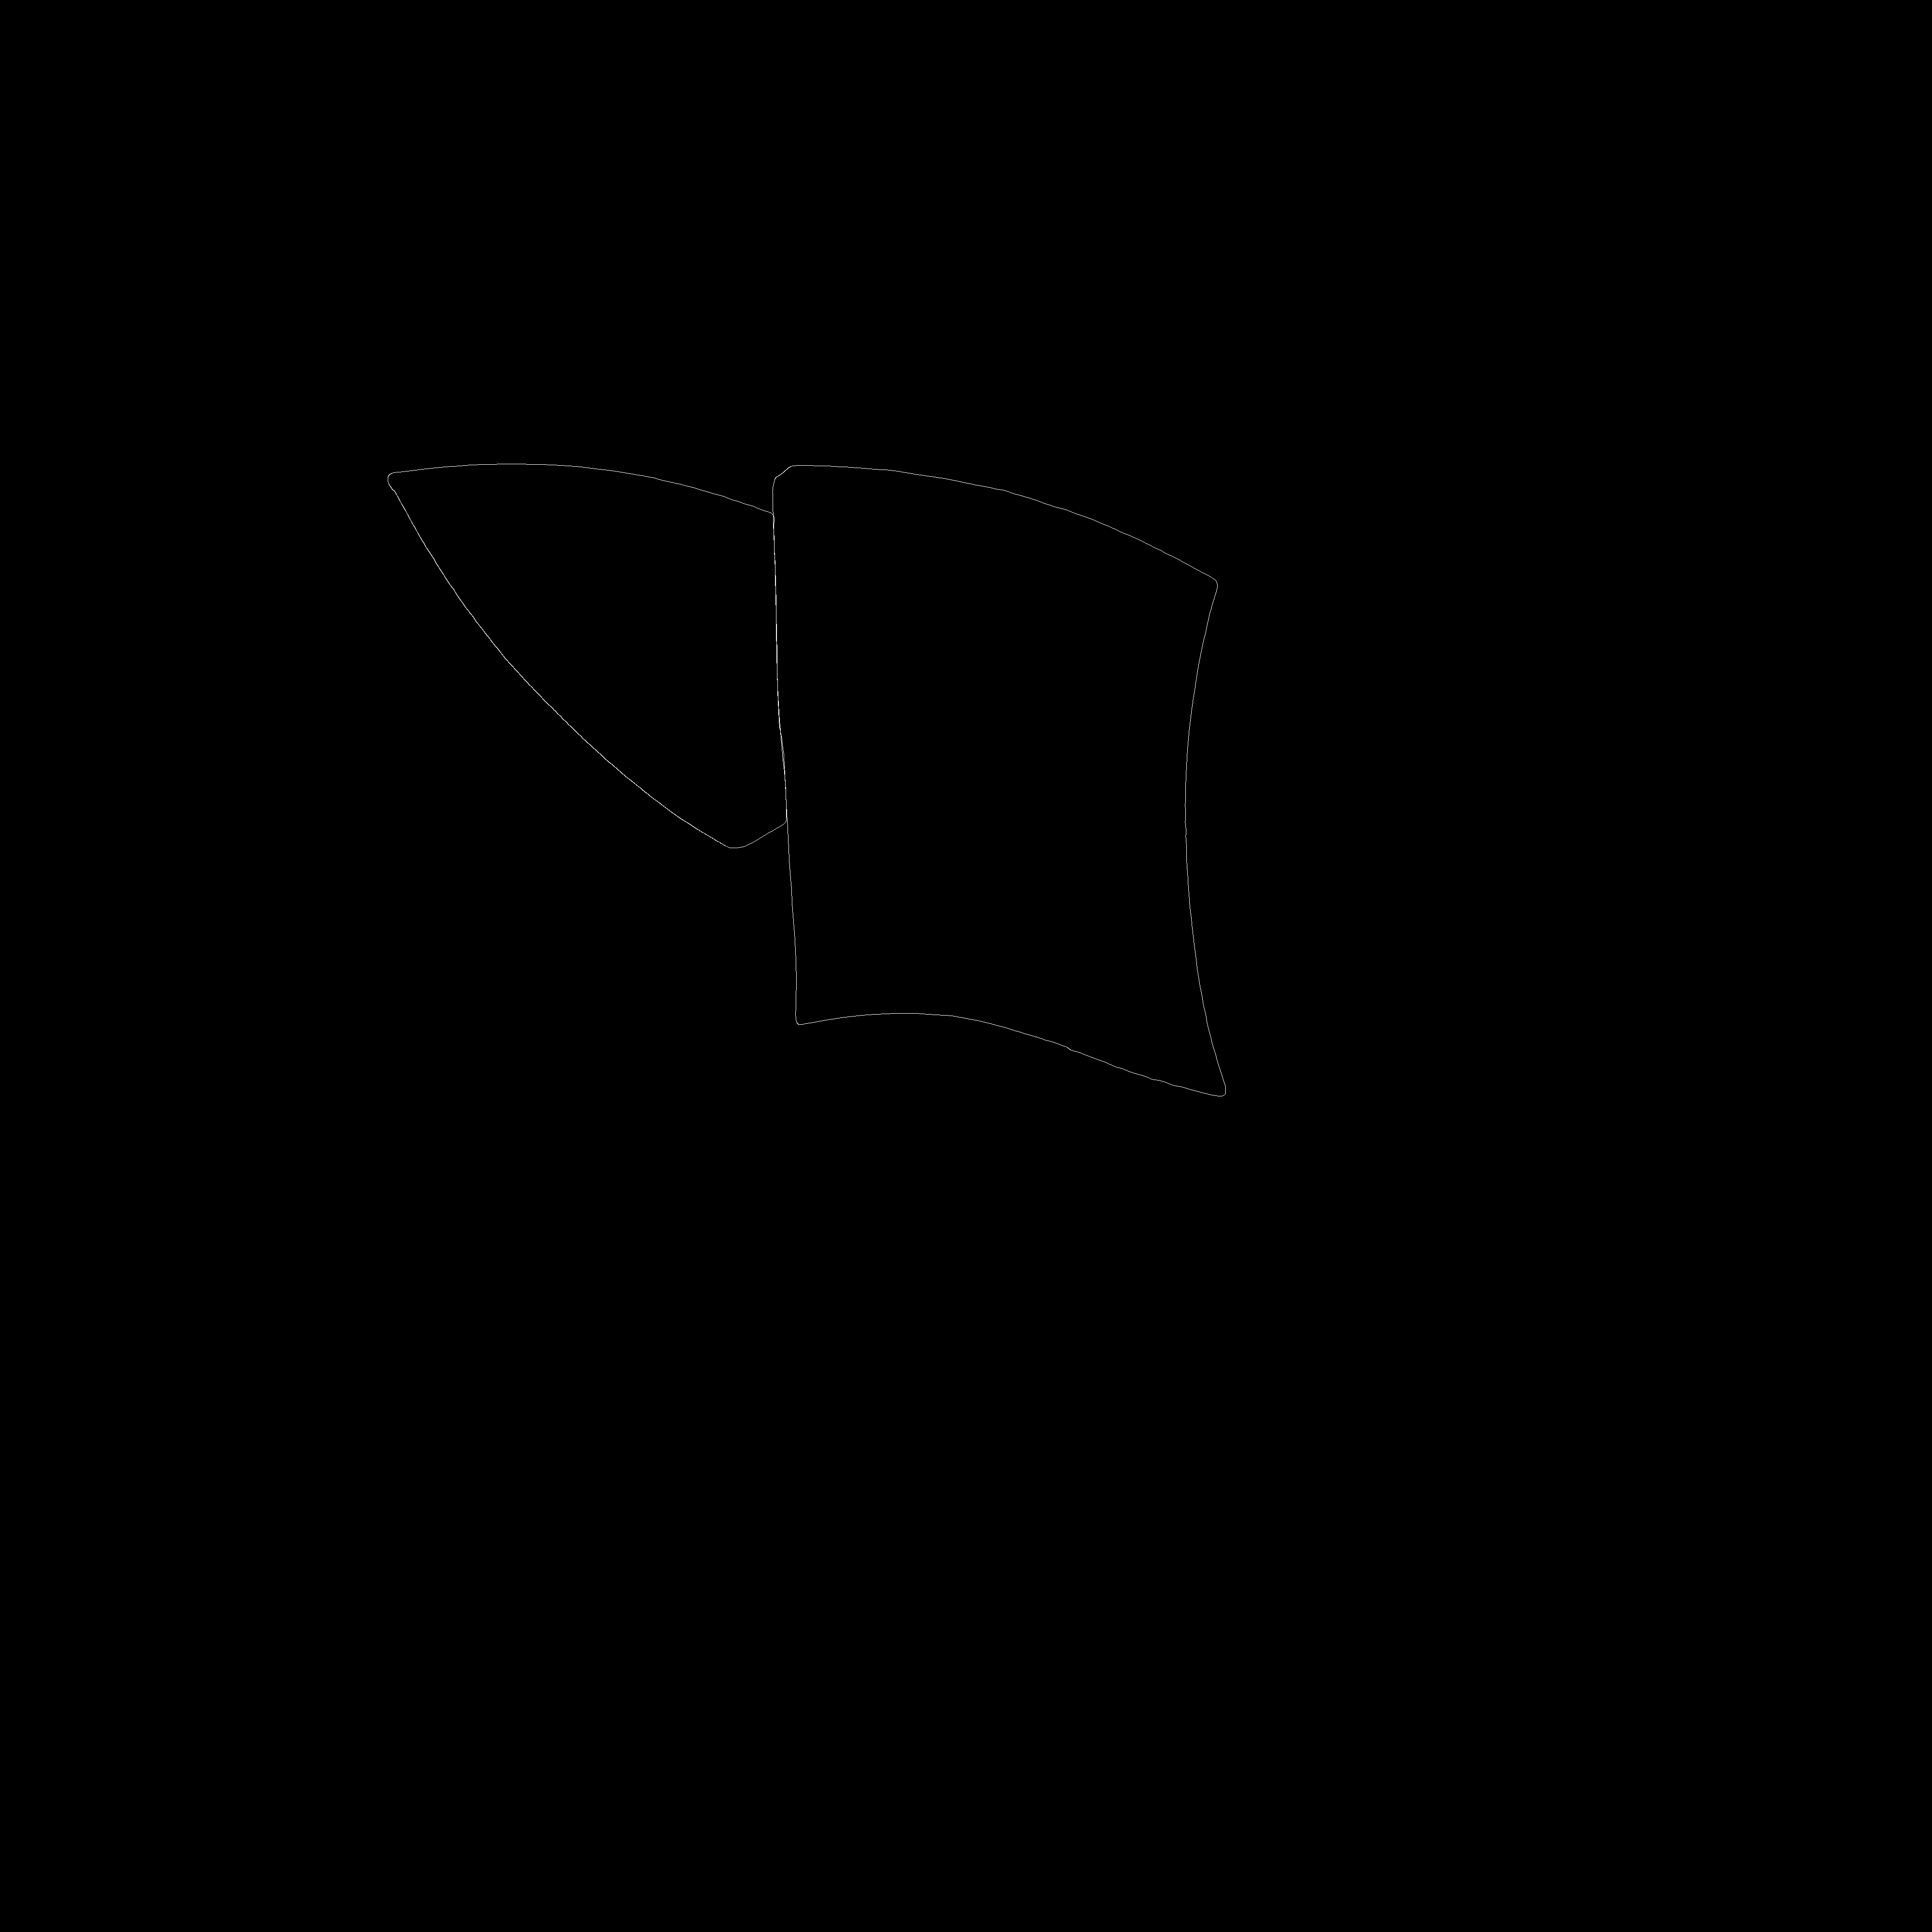

In [ ]:
#ATTACCA I PEZZI
edge_1 = contours[1].copy()
edge_2 = contours[2].copy()
edge_min = min((edge_1, edge_2), key=len)
edge_min = edge_min[::-1]
edge_max = max((edge_1, edge_2), key=len)

shift = edge_max[coords[0]:coords[1]][0] - edge_min[coords[2]:coords[3]][0]
edge_min += shift

angle_prova = get_angle(edge_max[coords[0]:coords[1]][-1], edge_max[coords[0]:coords[1]][0], edge_min[coords[2]:coords[3]][-1])
edge_min = rotate(edge_min, edge_min[coords[2]:coords[3]][0], angle_prova)
edge_min = np.ceil(edge_min).astype(int)

while(get_cosine_angle(edge_max[coords[0]:coords[1]][-1], edge_max[coords[0]:coords[1]][0], edge_min[coords[2]:coords[3]][-1]) < 0.90):
  angle_prova = get_angle(edge_max[coords[0]:coords[1]][-1], edge_max[coords[0]:coords[1]][0], edge_min[coords[2]:coords[3]][-1])
  edge_min = rotate(edge_min, edge_min[coords[2]:coords[3]][0], angle_prova)
  edge_min = np.ceil(edge_min).astype(int)

joined_coords = np.concatenate((edge_max, edge_min))

seg_edge = np.zeros((4016, 4016))
joined_coords += 500
x_coords, y_coords = joined_coords[:, 0], joined_coords[:, 1]
seg_edge[x_coords, y_coords] = 255
cv2_imshow(seg_edge)

In [ ]:
#SERVE PER CONTROLLARE SE UN PEZZO É DENTRO L'ALTRO
for point in edge_min:
  result = point_inside_polygon(point[0], point[1], edge_max)
  if (not result):
    print("nooo")

In [ ]:
#Questo plotta i due frammenti e due lati che combaciano
seg_edge = np.zeros((3016, 3016))
x_coords, y_coords = contours[2][:, 0], contours[2][:, 1]
seg_edge[x_coords, y_coords] = 255
cv2_imshow(seg_edge)
seg_edge = np.zeros((3016, 3016))
x_coords, y_coords = contours[2][350:550, 0], contours[2][350:550, 1]
seg_edge[x_coords, y_coords] = 255
cv2_imshow(seg_edge)

seg_edge = np.zeros((3016, 3016))
x_coords, y_coords = contours[1][:, 0], contours[1][:, 1]
seg_edge[x_coords, y_coords] = 255
cv2_imshow(seg_edge)
seg_edge = np.zeros((3016, 3016))
x_coords, y_coords = contours[1][2100:2300, 0], contours[1][2100:2300, 1]
seg_edge[x_coords, y_coords] = 255
cv2_imshow(seg_edge)


In [ ]:
edge_min = contours[2].copy()
edge_min = edge_min[::-1]
seg_edge = np.zeros((4016, 6016))
x_coords, y_coords = edge_min[2000:2800, 0], edge_min[2000:2800, 1]
seg_edge[x_coords, y_coords] = 255
cv2_imshow(seg_edge)

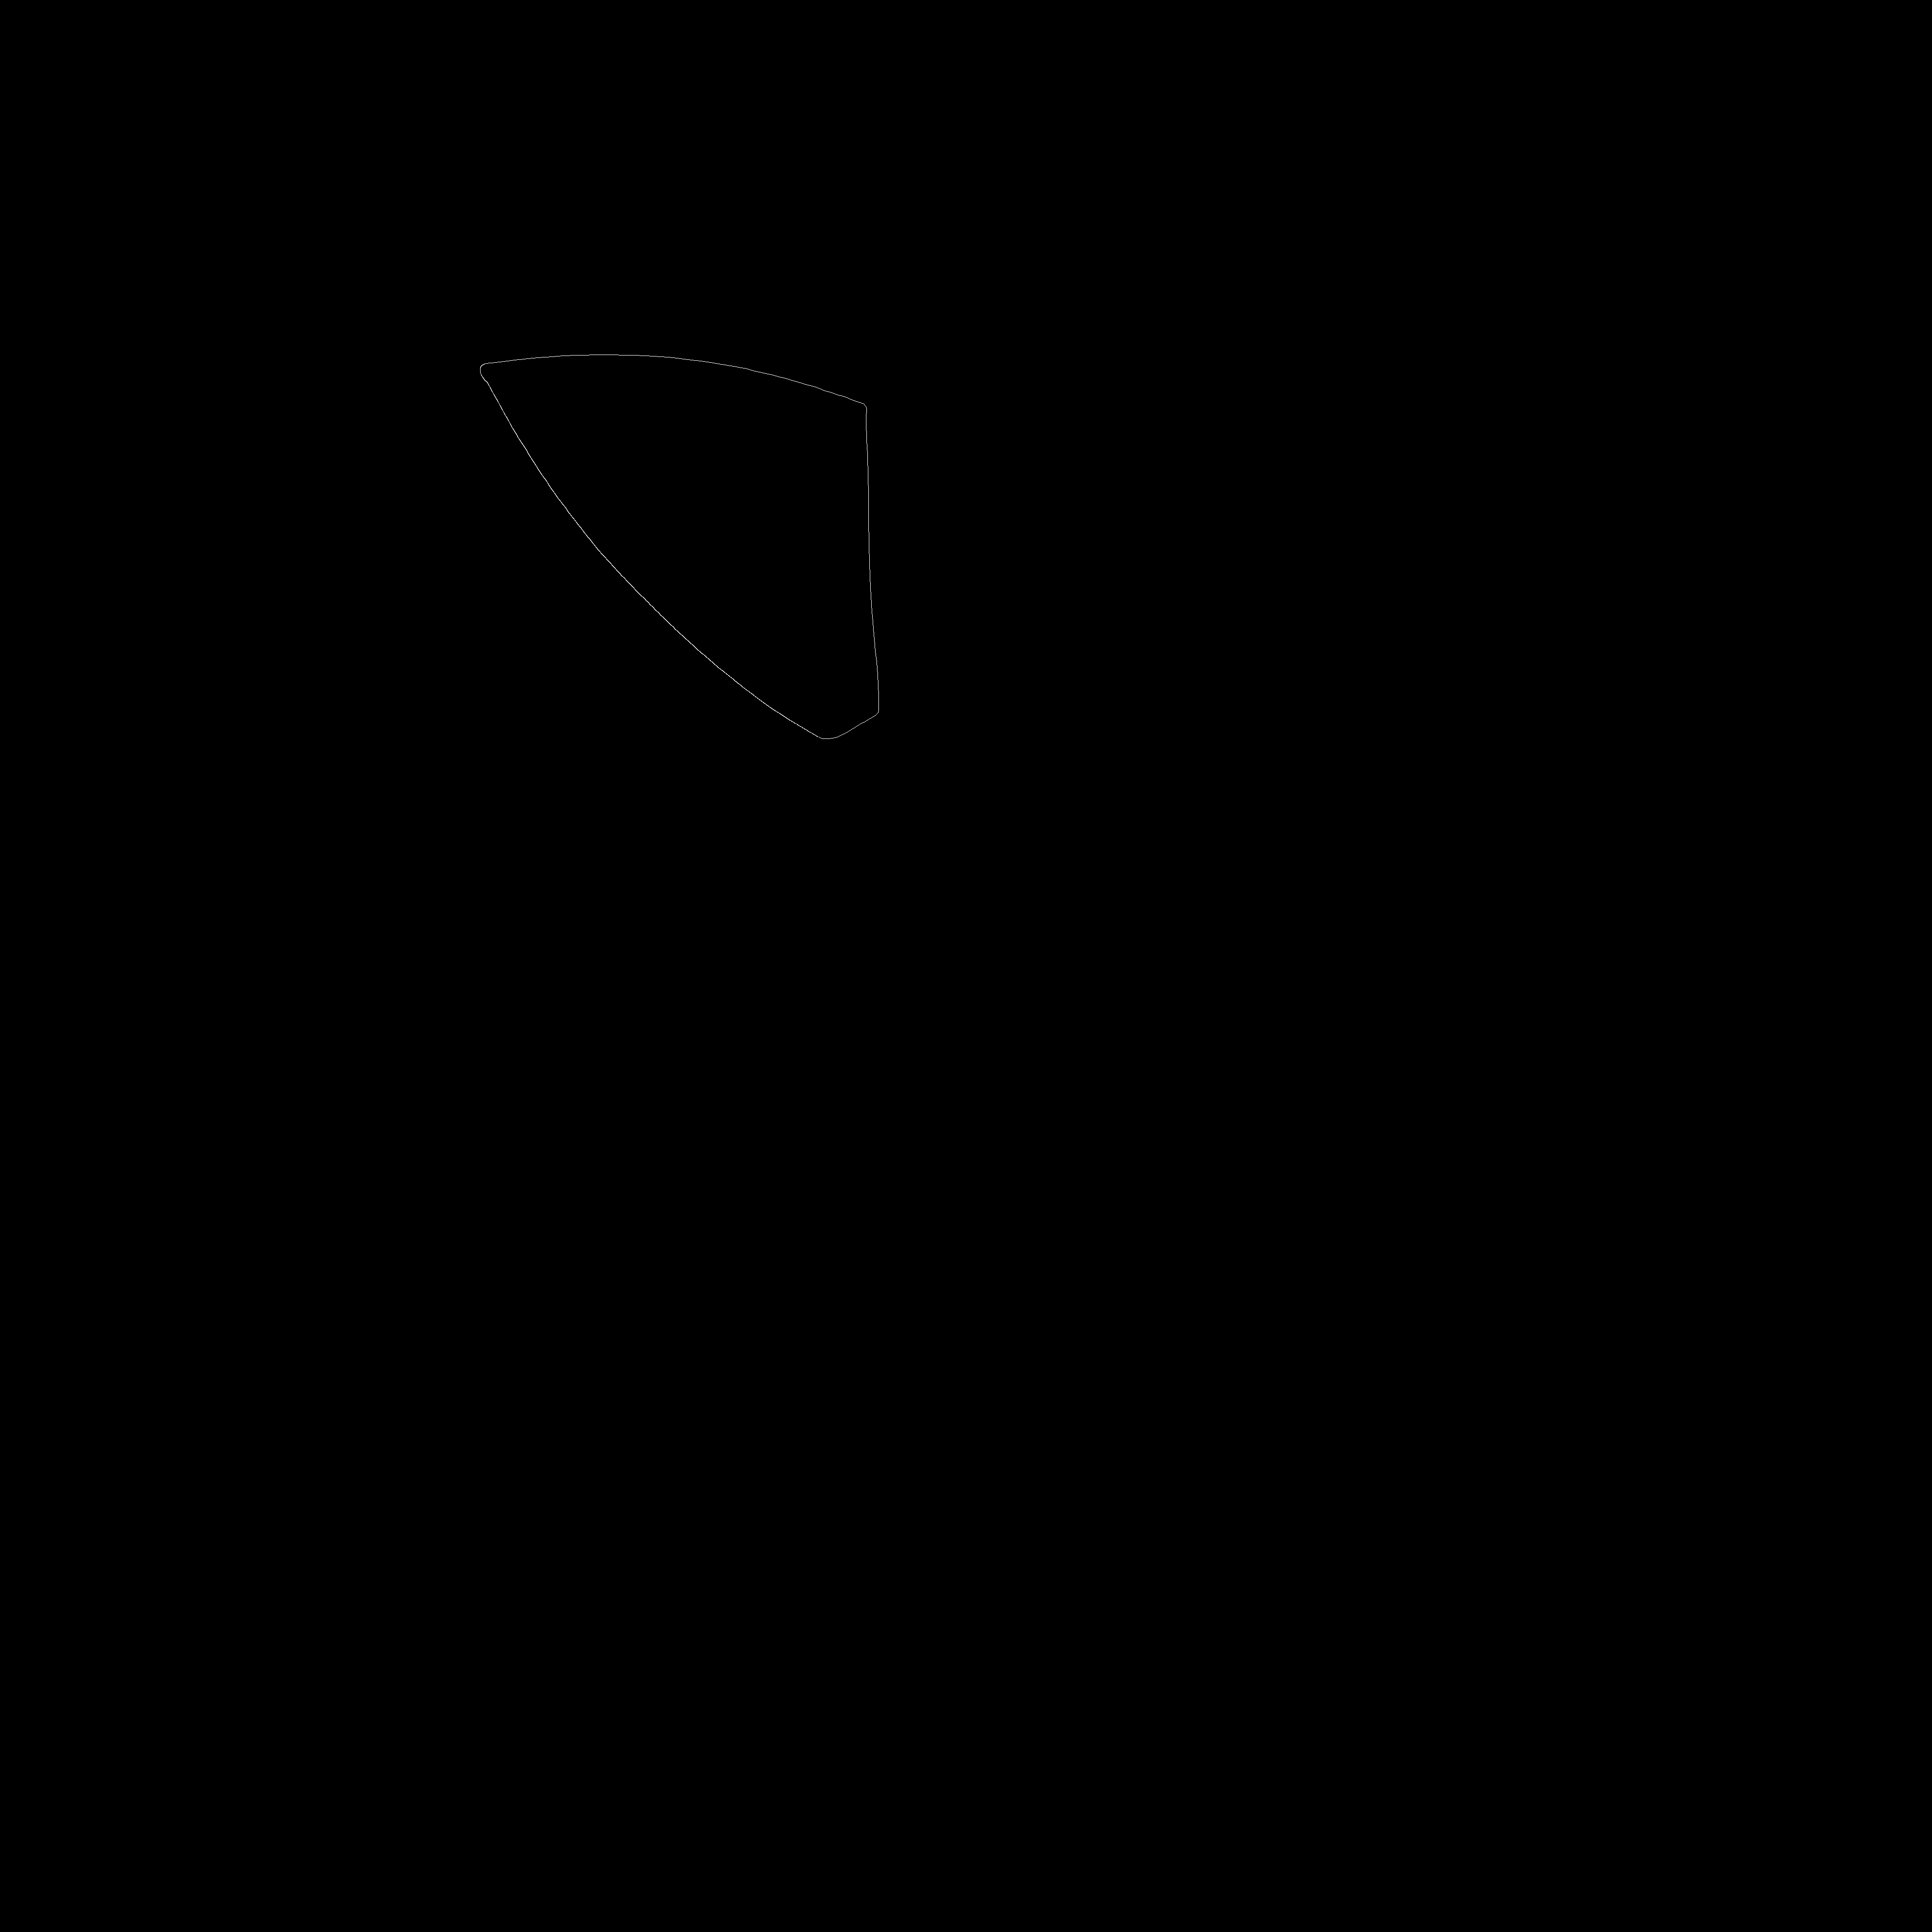

In [ ]:
seg_edge = np.zeros((4016, 4016))
x_coords, y_coords = contours[1][:, 0], contours[1][:, 1]
seg_edge[x_coords, y_coords] = 255
cv2_imshow(seg_edge)

In [ ]:
#QUESTO ATTACCA BENE L'ELEFANTE CON IL PEZZO CURVO MA PERCHÉ HO DEBUGGATO

# contours[0], contours[2], 400
edge_1 = contours[0].copy()
edge_2 = contours[2].copy()
min_distance = float('inf')
min_coords = None
edge_min = min((edge_1, edge_2), key=len)
edge_min = edge_min[::-1]
edge_max = max((edge_1, edge_2), key=len)
len_max = len(edge_max)
for x in range(4800, len_max - 400, 50):
  for y in range(2000, len(edge_min) - 400, 50):
    if(x >= 4800 and (x+400) <= 6400 and y >= 2000 and (y+400) <= 3600):
      #seg_edge = np.zeros((4016, 4016))
      #x_coords, y_coords = edge_max[x:x+400, 0], edge_max[x:x+400, 1]
      #seg_edge[x_coords, y_coords] = 255
      #cv2_imshow(seg_edge)
      #seg_edge = np.zeros((4016, 4016))
      #x_coords, y_coords = edge_min[y:y+400, 0], edge_min[y:y+400, 1]
      #seg_edge[x_coords, y_coords] = 255
      #cv2_imshow(seg_edge)

      distance = eval_match(edge_min[y:y+400], edge_max[x:x+400])
      #print("Lenght -> ", check_length(edge_min[y:y+400], edge_max[x:x+400]))
      #print("Distanza -> ", distance)
    #else:
      #distance = eval_match(edge_min[y:y+400], edge_max[x:x+400])

    #if distance < 3.0:
    if distance < min_distance:
      #dizionario.update({distance:(x, x + size, y, y + size)} )
      #if (not attach_fragments(edge_min, edge_max, x, x+size, y, y+size)):
      min_distance = distance
      min_coords = (x, x + 400, y, y + 400)


#return 0, (0,0,0,0)

In [ ]:
coords = min_coords
print(min_distance)

2.851370417102866


In [ ]:
with open('contours.json', 'r') as f:
  array_list = json.load(f)

contours = [np.array(arr) for arr in array_list]

In [8]:
from enum import Enum
def contours_simplifier(edge):
  class Status(Enum):
    FINISH = 0
    STRAIGHT = 1
    STAIRS = 2
    DIAGONAL = 3
  status = Status.STRAIGHT
  while status != Status.FINISH:
    to_del = []
    if status == Status.STRAIGHT:
      for i in range(len(edge) - 1):
        if (edge[i - 1][0] == edge[i][0] == edge[i + 1][0]) or (edge[i - 1][1] == edge[i][1] == edge[i + 1][1]):
          to_del.append(i)
      edge = np.delete(edge, to_del, 0)
      if len(to_del) == 0:
        status = status.STAIRS
    if status == Status.STAIRS:
      for i in range(len(edge) - 1):
        if abs(edge[i - 1][0] - edge[i + 1][0]) == 1 and abs(edge[i - 1][1] - edge[i + 1][1]) == 1: # il pixel prima ed il pixel dopo si toccano coi vertici
          to_del.append(i)
      edge = np.delete(edge, to_del, 0)
      if len(to_del) == 0:
        status = status.DIAGONAL
    if status == Status.DIAGONAL:
      for i in range(len(edge) - 1):
        if abs(edge[i - 1][0] - edge[i + 1][0]) == abs(edge[i - 1][1] - edge[i + 1][1]):
          to_del.append(i)
      edge = np.delete(edge, to_del, 0)
      if len(to_del) == 0:
        status = status.FINISH
  return edge

In [ ]:
test_segment8 = np.array([[  0, 255, 255,   0,   0,   0,   0],
                          [  0,   0, 255,   0,   0,   0,   0],
                          [  0,   0, 255, 255,   0,   0,   0],
                          [  0,   0,   0, 255,   0,   0,   0],
                          [  0,   0,   0,   0,   0,   0,   0],
                          [  0,   0,   0,   0,   0,   0,   0],
                          [  0,   0,   0,   0,   0,   0,   0]])

test_diagonal = np.array([[  0, 255, 255,   0,   0,   0,   0],
                          [255,   0,   0, 255,   0,   0,   0],
                          [  0, 255,   0,   0, 255,   0,   0],
                          [  0,   0, 255,   0,   0, 255,   0],
                          [  0,   0,   0, 255,   0,   0, 255],
                          [  0,   0,   0,   0, 255,   0, 255],
                          [  0,   0,   0,   0,   0, 255,   0]])

#if (edge[i - 1][0] == edge[i][0] and abs(edge[i][0] - edge[i + 1][0]) == 1) or (edge[i - 1][1] == edge[i][1] and abs(edge[i][1] - edge[i + 1][1]) == 1):
arr8 = manhattan_drow_edge(test_segment8, find_start(test_segment8))
diag = manhattan_drow_edge(test_diagonal, find_start(test_diagonal))

In [9]:
def get_quad_distance(A, B):
  return ((B[0] - A[0])**2) + ((B[1] - A[1])**2)

import math
def distance(point1, point2):
		return round(math.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2), 2)

def get_distances(arr):
  results = []
  for i in range(len(arr)):
    results.append(get_quad_distance(arr[i], arr[i - 1]))
    #results.append(distance(arr[i], arr[i - 1]))
  return results

In [10]:
def getX(arr):
  results = []
  for x in arr:
    results.append(x[1])
  return results

def difference(arr):
  return [abs(arr[x] - arr[x - 1]) for x in range(len(arr))]

In [11]:
#Match a finestra fissa
#i -> dimensione finestra

from google.colab import output
def new_match(arr1, arr2):
  edge_1 = contours_simplifier(arr1.copy())
  edge_2 = contours_simplifier(arr2.copy())
  min_distance = float('inf')
  min_coords = None
  edge_min = min((edge_1, edge_2), key=len)
  edge_min = edge_min[::-1]
  edge_max = max((edge_1, edge_2), key=len)
  len_max = len(edge_max)
  len_min = len(edge_min)
  edge_max_sides = get_distances(edge_max)
  edge_min_sides = get_distances(edge_min)
  i = 100
  for x in range(0, len_max - i, 10):
    for y in range(0, len_min - i, 10):
      if 0.5 < sum(edge_max_sides[x+1:x+i+1]) / sum(edge_min_sides[y+1:y+i+1]) < 2:
        distance = eval_match(edge_min[y:y+i], edge_max[x:x+i])

      #if distance < 3.0:
        if distance < min_distance:
        #dizionario.update({distance:(x, x + size, y, y + size)} )
          if (not attach_fragments(edge_min, edge_max, x, x + i, y, y + i)):
            min_distance = distance
            min_coords = (x, x + i, y, y + i)
  return min_distance, min_coords

In [12]:
#Ridefinizione del check di sovrapposizione con fine tuning per i bordi semplificati

def check_inside_contours(edge_min, edge_max):
  c = 0
  for point in edge_min:
    result = point_inside_polygon(point[0], point[1], edge_max)
    if (result):
      c += 1
    else:
      c = 0

    if c > 30:
      return True
  return False

In [27]:
#ATTACCA I PEZZI
def merge_visualize(idx1, idx2, coords):
  edge_1 = contours_simplifier(contours[idx1].copy())
  edge_2 = contours_simplifier(contours[idx2].copy())
  edge_min = min((edge_1, edge_2), key=len)
  edge_min = edge_min[::-1]
  edge_max = max((edge_1, edge_2), key=len)

  shift = edge_max[coords[0]:coords[1]][0] - edge_min[coords[2]:coords[3]][0]
  edge_min += shift

  angle_prova = get_angle(edge_max[coords[0]:coords[1]][-1], edge_max[coords[0]:coords[1]][0], edge_min[coords[2]:coords[3]][-1])
  edge_min = rotate(edge_min, edge_min[coords[2]:coords[3]][0], angle_prova)
  edge_min = np.ceil(edge_min).astype(int)

  while(get_cosine_angle(edge_max[coords[0]:coords[1]][-1], edge_max[coords[0]:coords[1]][0], edge_min[coords[2]:coords[3]][-1]) < 0.90):
    angle_prova = get_angle(edge_max[coords[0]:coords[1]][-1], edge_max[coords[0]:coords[1]][0], edge_min[coords[2]:coords[3]][-1])
    edge_min = rotate(edge_min, edge_min[coords[2]:coords[3]][0], angle_prova)
    edge_min = np.ceil(edge_min).astype(int)

  joined_coords = np.concatenate((edge_max, edge_min))

  seg_edge = np.zeros((4016, 4016))
  joined_coords += 500
  x_coords, y_coords = joined_coords[:, 0], joined_coords[:, 1]
  seg_edge[x_coords, y_coords] = 255
  cv2_imshow(seg_edge)

def merge_by_idx(idx1, idx2, coords):
  edge_1 = contours_simplifier(contours[idx1].copy())
  edge_2 = contours_simplifier(contours[idx2].copy())[::-1]

  shift = edge_1[coords[0]:coords[1]][0] - edge_2[coords[2]:coords[3]][0]
  edge_2 += shift

  angle_prova = get_angle(edge_1[coords[0]:coords[1]][-1], edge_1[coords[0]:coords[1]][0], edge_2[coords[2]:coords[3]][-1])
  edge_2 = rotate(edge_2, edge_2[coords[2]:coords[3]][0], angle_prova)
  edge_2 = np.ceil(edge_2).astype(int)

  while(get_cosine_angle(edge_1[coords[0]:coords[1]][-1], edge_1[coords[0]:coords[1]][0], edge_2[coords[2]:coords[3]][-1]) < 0.90):
    angle_prova = get_angle(edge_1[coords[0]:coords[1]][-1], edge_1[coords[0]:coords[1]][0], edge_2[coords[2]:coords[3]][-1])
    edge_2 = rotate(edge_2, edge_2[coords[2]:coords[3]][0], angle_prova)
    edge_2 = np.ceil(edge_2).astype(int)

  joined_coords = np.concatenate((edge_1, edge_2))

  seg_edge = np.zeros((6016, 6016))
  joined_coords += 500
  x_coords, y_coords = joined_coords[:, 0], joined_coords[:, 1]
  seg_edge[x_coords, y_coords] = 255
  cv2_imshow(seg_edge)

In [14]:
#Match a dimensione della sliding window variabile

from google.colab import output

def new_match(arr1, arr2):
  edge_1 = contours_simplifier(arr1.copy())
  edge_2 = contours_simplifier(arr2.copy())
  min_distance = float('inf')
  min_coords = None
  edge_min = min((edge_1, edge_2), key=len)
  edge_min = edge_min[::-1]
  edge_max = max((edge_1, edge_2), key=len)
  len_max = len(edge_max)
  len_min = len(edge_min)
  edge_max_sides = get_distances(edge_max)
  edge_min_sides = get_distances(edge_min)
  for i in range(int(len_min / 8), int(len_min / 3), 10):  #10 4
    output.clear()
    print(round(((i - (len_min/8)) * 100) / ((len_min/3) - (len_min/8)), 2), "%")
    for j in range(i - 5, i + 5):
      for x in range(0, len_max - j, 10):
        for y in range(0, len_min - i, 10):
          if 0.99 < sum(edge_max_sides[x+1:x+j+1]) / sum(edge_min_sides[y+1:y+i+1]) < 1.01:
            distance = eval_match(edge_min[y:y+i], edge_max[x:x+j])
            if distance < min_distance:
            #dizionario.update({distance:(x, x + size, y, y + size)} )
              if (not attach_fragments(edge_min, edge_max, x, x + j, y, y + i)):
                min_distance = distance
                min_coords = (x, x + j, y, y + i)
  return min_distance, min_coords

In [15]:
#Match a dimensioni della sliding windows multiple ma prefissate

from google.colab import output

def new_match(arr1, arr2):
  edge_1 = contours_simplifier(arr1.copy())
  edge_2 = contours_simplifier(arr2.copy())
  min_distance = float('inf')
  min_coords = None
  edge_min = min((edge_1, edge_2), key=len)
  edge_min = edge_min[::-1]
  edge_max = max((edge_1, edge_2), key=len)
  len_max = len(edge_max)
  len_min = len(edge_min)
  edge_max_sides = get_distances(edge_max)
  edge_min_sides = get_distances(edge_min)
  dimensions = [x for x in range(80, 260, 20)]
  for i in dimensions:  #10 4
    #output.clear()
    #print(f"{round((i - 80) / 2)}%")
    for j in dimensions:
      for x in range(0, len_max - j, 10):
        for y in range(0, len_min - i, 10):
          if 0.99 < sum(edge_max_sides[x+1:x+j+1]) / sum(edge_min_sides[y+1:y+i+1]) < 1.01:
            distance = eval_match(edge_min[y:y+i], edge_max[x:x+j])
            if distance < min_distance:
            #dizionario.update({distance:(x, x + size, y, y + size)} )
              if (not attach_fragments(edge_min, edge_max, x, x + j, y, y + i)):
                min_distance = distance
                min_coords = (x, x + j, y, y + i)
  return min_distance, min_coords

In [16]:
#Match a dimensioni della sliding windows multiple ma prefissate per pezzi multipli

from google.colab import output

def new_match_for_multi(arr1, arr2, best_score):
  edge_1 = contours_simplifier(arr1.copy())
  edge_2 = contours_simplifier(arr2.copy())
  min_distance = float('inf')
  min_coords = None
  edge_min = min((edge_1, edge_2), key=len)
  edge_min = edge_min[::-1]
  edge_max = max((edge_1, edge_2), key=len)
  len_max = len(edge_max)
  len_min = len(edge_min)
  edge_max_sides = get_distances(edge_max)
  edge_min_sides = get_distances(edge_min)
  dimensions = [x for x in range(80, 260, 20)]
  for i in dimensions:  #10 4
    #output.clear()
    #print(f"{round((i - 80) / 2)}%")
    for j in dimensions:
      for x in range(0, len_max - j, 10):
        for y in range(0, len_min - i, 10):
          if 0.99 < sum(edge_max_sides[x+1:x+j+1]) / sum(edge_min_sides[y+1:y+i+1]) < 1.01:
            distance = eval_match(edge_min[y:y+i], edge_max[x:x+j])
            if distance < best_score and distance < min_distance:
            #dizionario.update({distance:(x, x + size, y, y + size)} )
              if (not attach_fragments(edge_min, edge_max, x, x + j, y, y + i)):
                min_distance = distance
                min_coords = (x, x + j, y, y + i)

  return min_distance, min_coords

In [ ]:
score, coords = new_match(contours[2], contours[3])   #1, 3, 400
print(score)
print(coords)

1.5898158387132886
(1000, 1100, 330, 430)


In [17]:
def test_match(idx1, idx2):
  min_distance, min_coords = new_match(contours[idx1], contours[idx2])
  print(min_distance)
  print(coords)
  merge_visualize(idx1, idx2, min_coords)
#test_match(0, 1)

Analizing: (440, 750)
Distance: 10459
Analizing: (757, 948)
Distance: 876
Analizing: (957, 1141)
Distance: 6611
Analizing: (1146, 1266)
Distance: 30374
__Winner__
4.844773759642411
(757, 948, 507, 512)


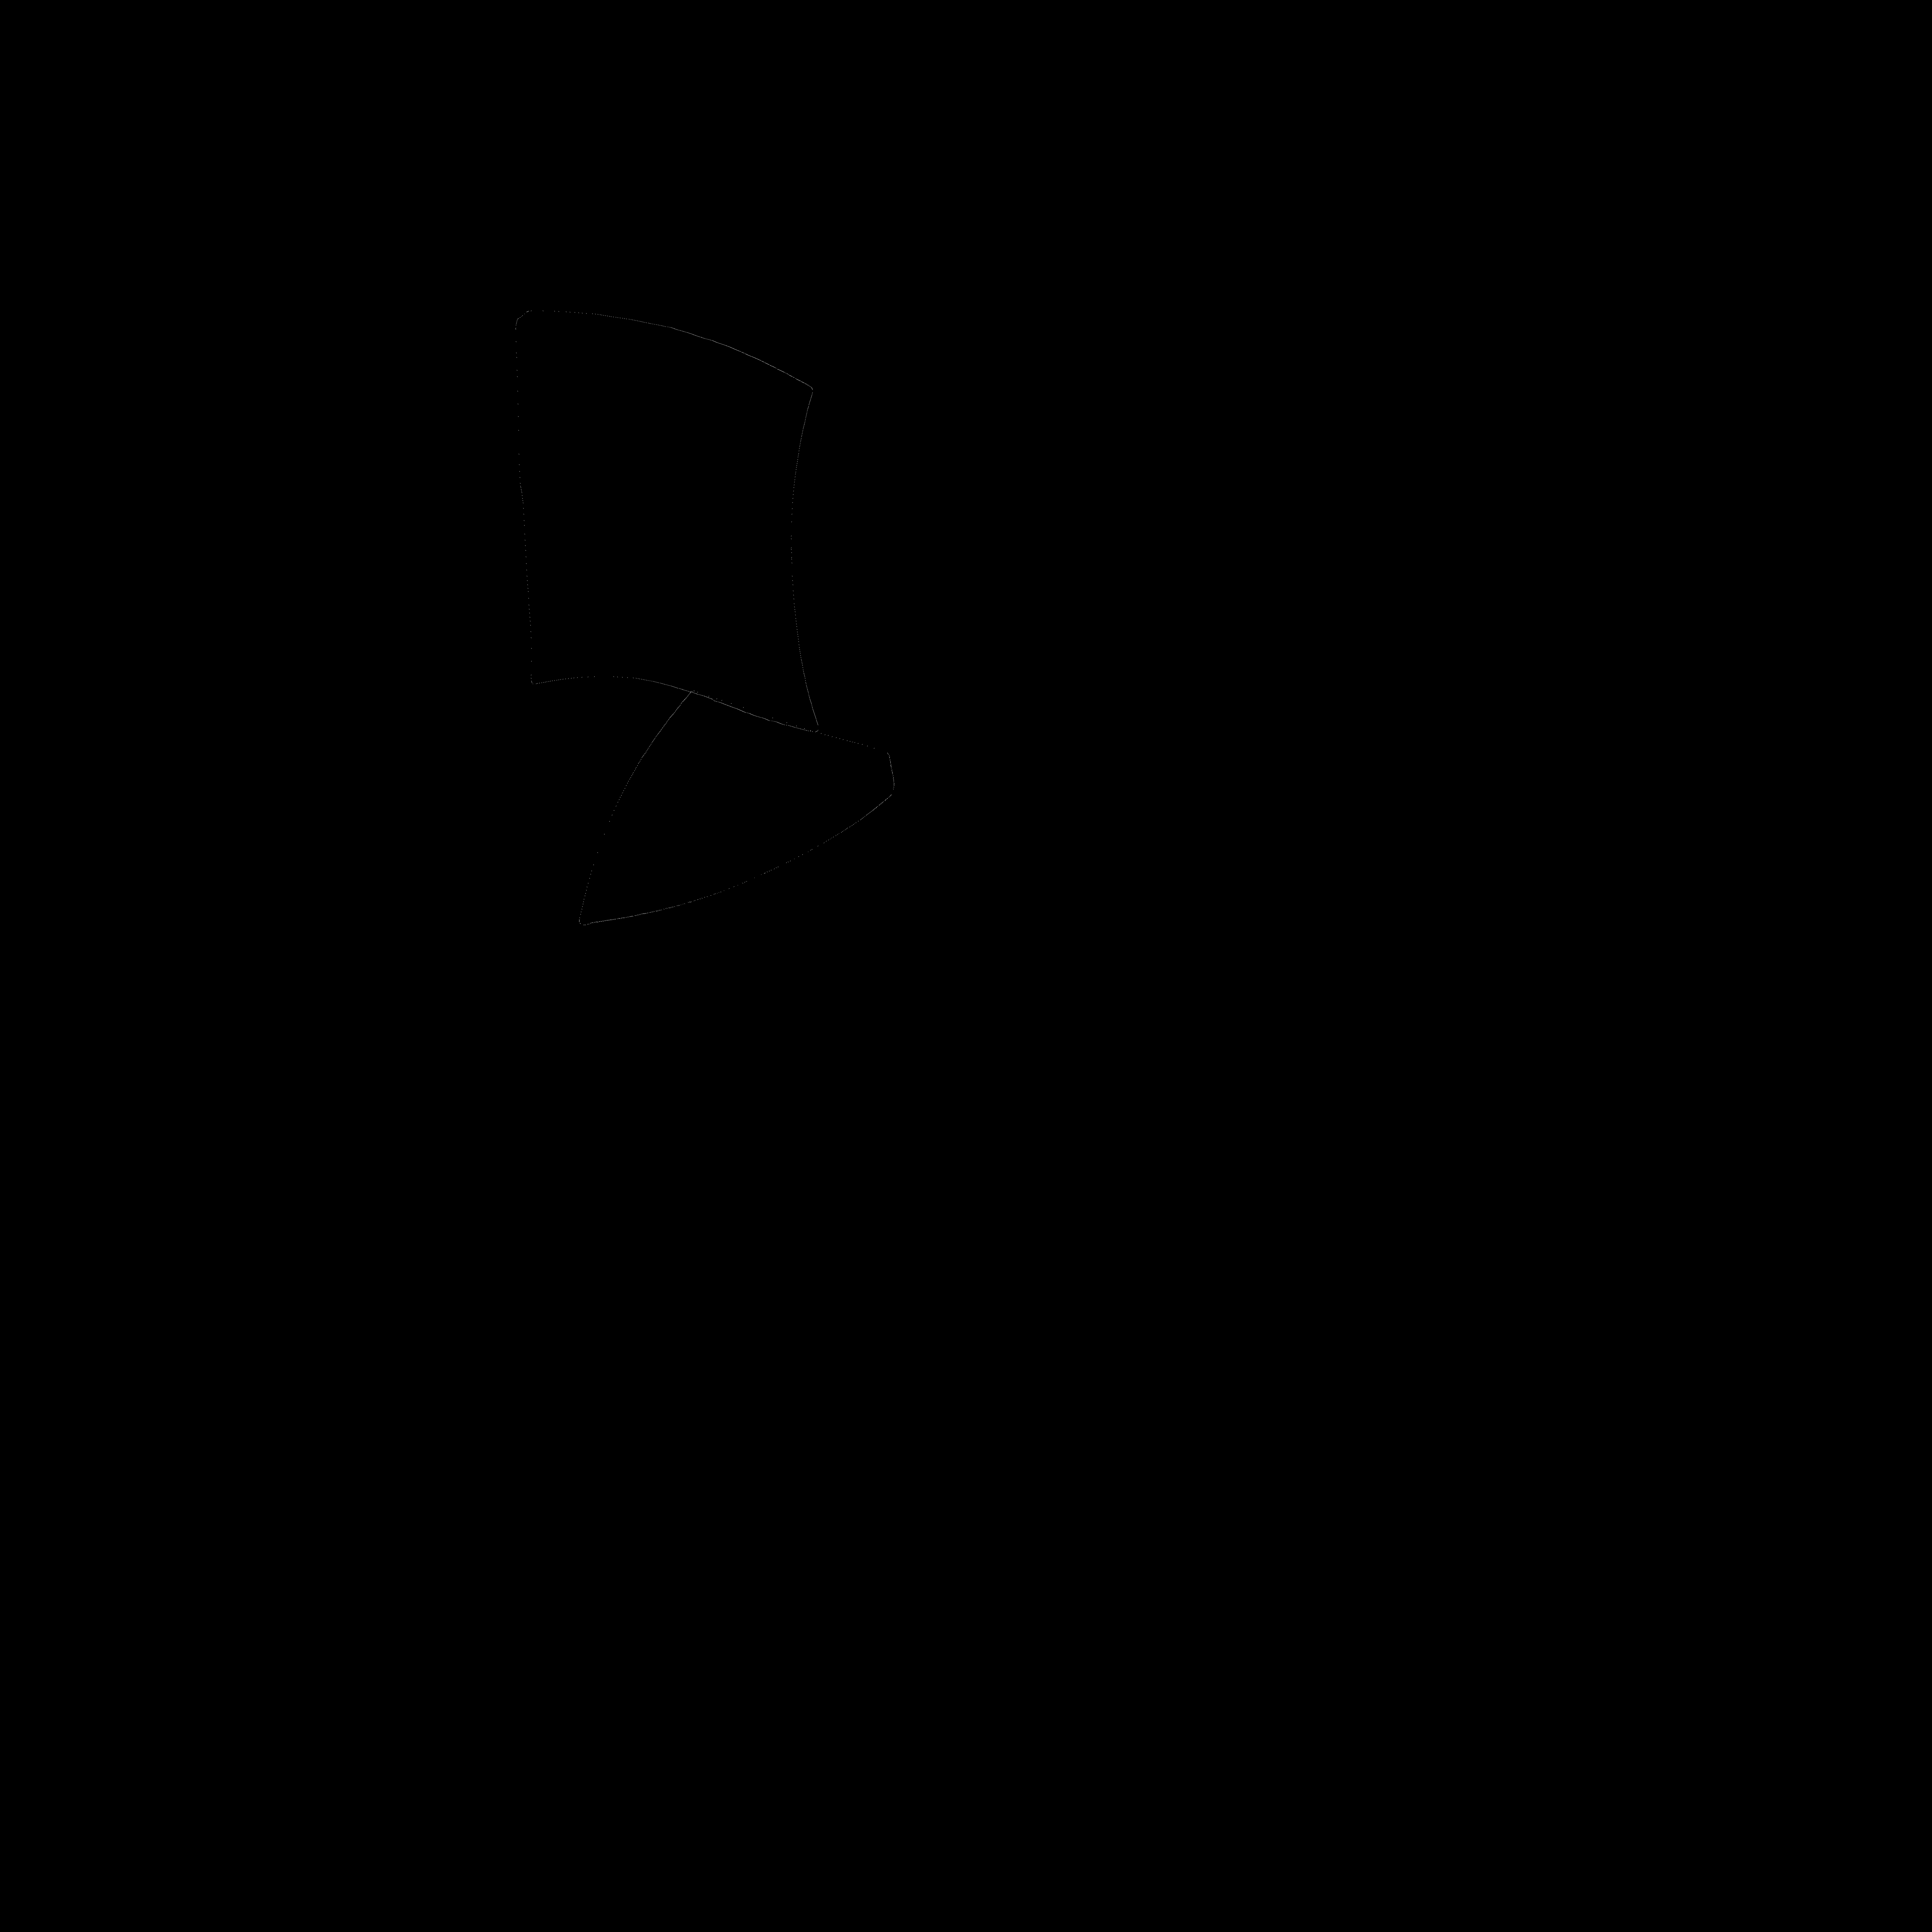

In [30]:
from google.colab import output

def find_corners(arr):
  corners = []
  length = len(arr)
  for idx, point in enumerate(arr):
    angle = get_angle(arr[idx - 3], point, arr[(idx + 3) % length])
    if angle % 180 < 150:
      corners.append(idx)
  distances = get_distances([arr[i] for i in corners])
  results = []
  for idx, val in enumerate(corners):
    if distances[idx] > 300 or distances[(idx + 1)%len(corners)] > 300:
      results.append(val)
  return results

def match_whole_edges(arr1, arr2):
  edge1 = contours_simplifier(arr1.copy())
  edge2 = contours_simplifier(arr2.copy())[::-1]

  min_distance = float('inf')
  min_coords = None

  edge_1_sides = get_distances(edge1)
  edge_2_sides = get_distances(edge2)

  corners_idx = find_corners(edge1)

  stretching = True

  for idx, corner in enumerate(corners_idx[:-1]):
    length1 = sum(edge_1_sides[corner:corners_idx[idx+1]])
    i, j = 0, 1
    if length1 > 300:
      print(f"Analizing: {corner, corners_idx[idx+1]}")
      print(f"Distance: {length1}")
      while i < len(edge2) and j < len(edge2):
        window = edge2[i:j]
        length2 = sum(edge_2_sides[i:j])
        if length2 > 0 and 0.99 < length1 / length2 < 1.01:
          distance = eval_match(window, edge1[corner:corners_idx[idx+1]])
          if distance < min_distance:
            if (not attach_fragments(edge2, edge1, corner, corners_idx[idx+1], i, j)):
                min_distance = distance
                min_coords = (corner, corners_idx[idx+1], i, j)
          if stretching:
            j = j + 1
          else:
            i = i + 1
        elif length1 > length2:
          j = j + 1
          stretching = True
        else:
          i = i + 1
          stretching = False
  return min_distance, min_coords

def test_last_match(idx1, idx2):
  min_distance, min_coords = match_whole_edges(contours[idx1], contours[idx2])
  print("__Winner__")
  print(min_distance)
  print(min_coords)
  merge_by_idx(idx1, idx2, min_coords)
test_last_match(1, 3)

In [ ]:
find_corners(contours[1])

[2926, 4063]

In [ ]:
prova = contours_simplifier(contours[2].copy())[::-1]
len(prova)

1313

In [ ]:
find_corners(contours_simplifier(contours[3]))

[22, 24, 75, 83, 345, 442, 444, 509]

In [ ]:
score, coords = match_long_edges(contours[2], contours[3])   #1, 3, 400
print(score)
print(coords)

In [ ]:
seg_edge = np.zeros((4016, 4016))
x_coords, y_coords = contours[2][:, 0], contours[][:, 1]
seg_edge[x_coords, y_coords] = 255
cv2_imshow(seg_edge)

[1626, 1629, 1682, 1682, 1776, 1773, 644, 629]
[1156, 1159, 1724, 1726, 2044, 2047, 1913, 1882]


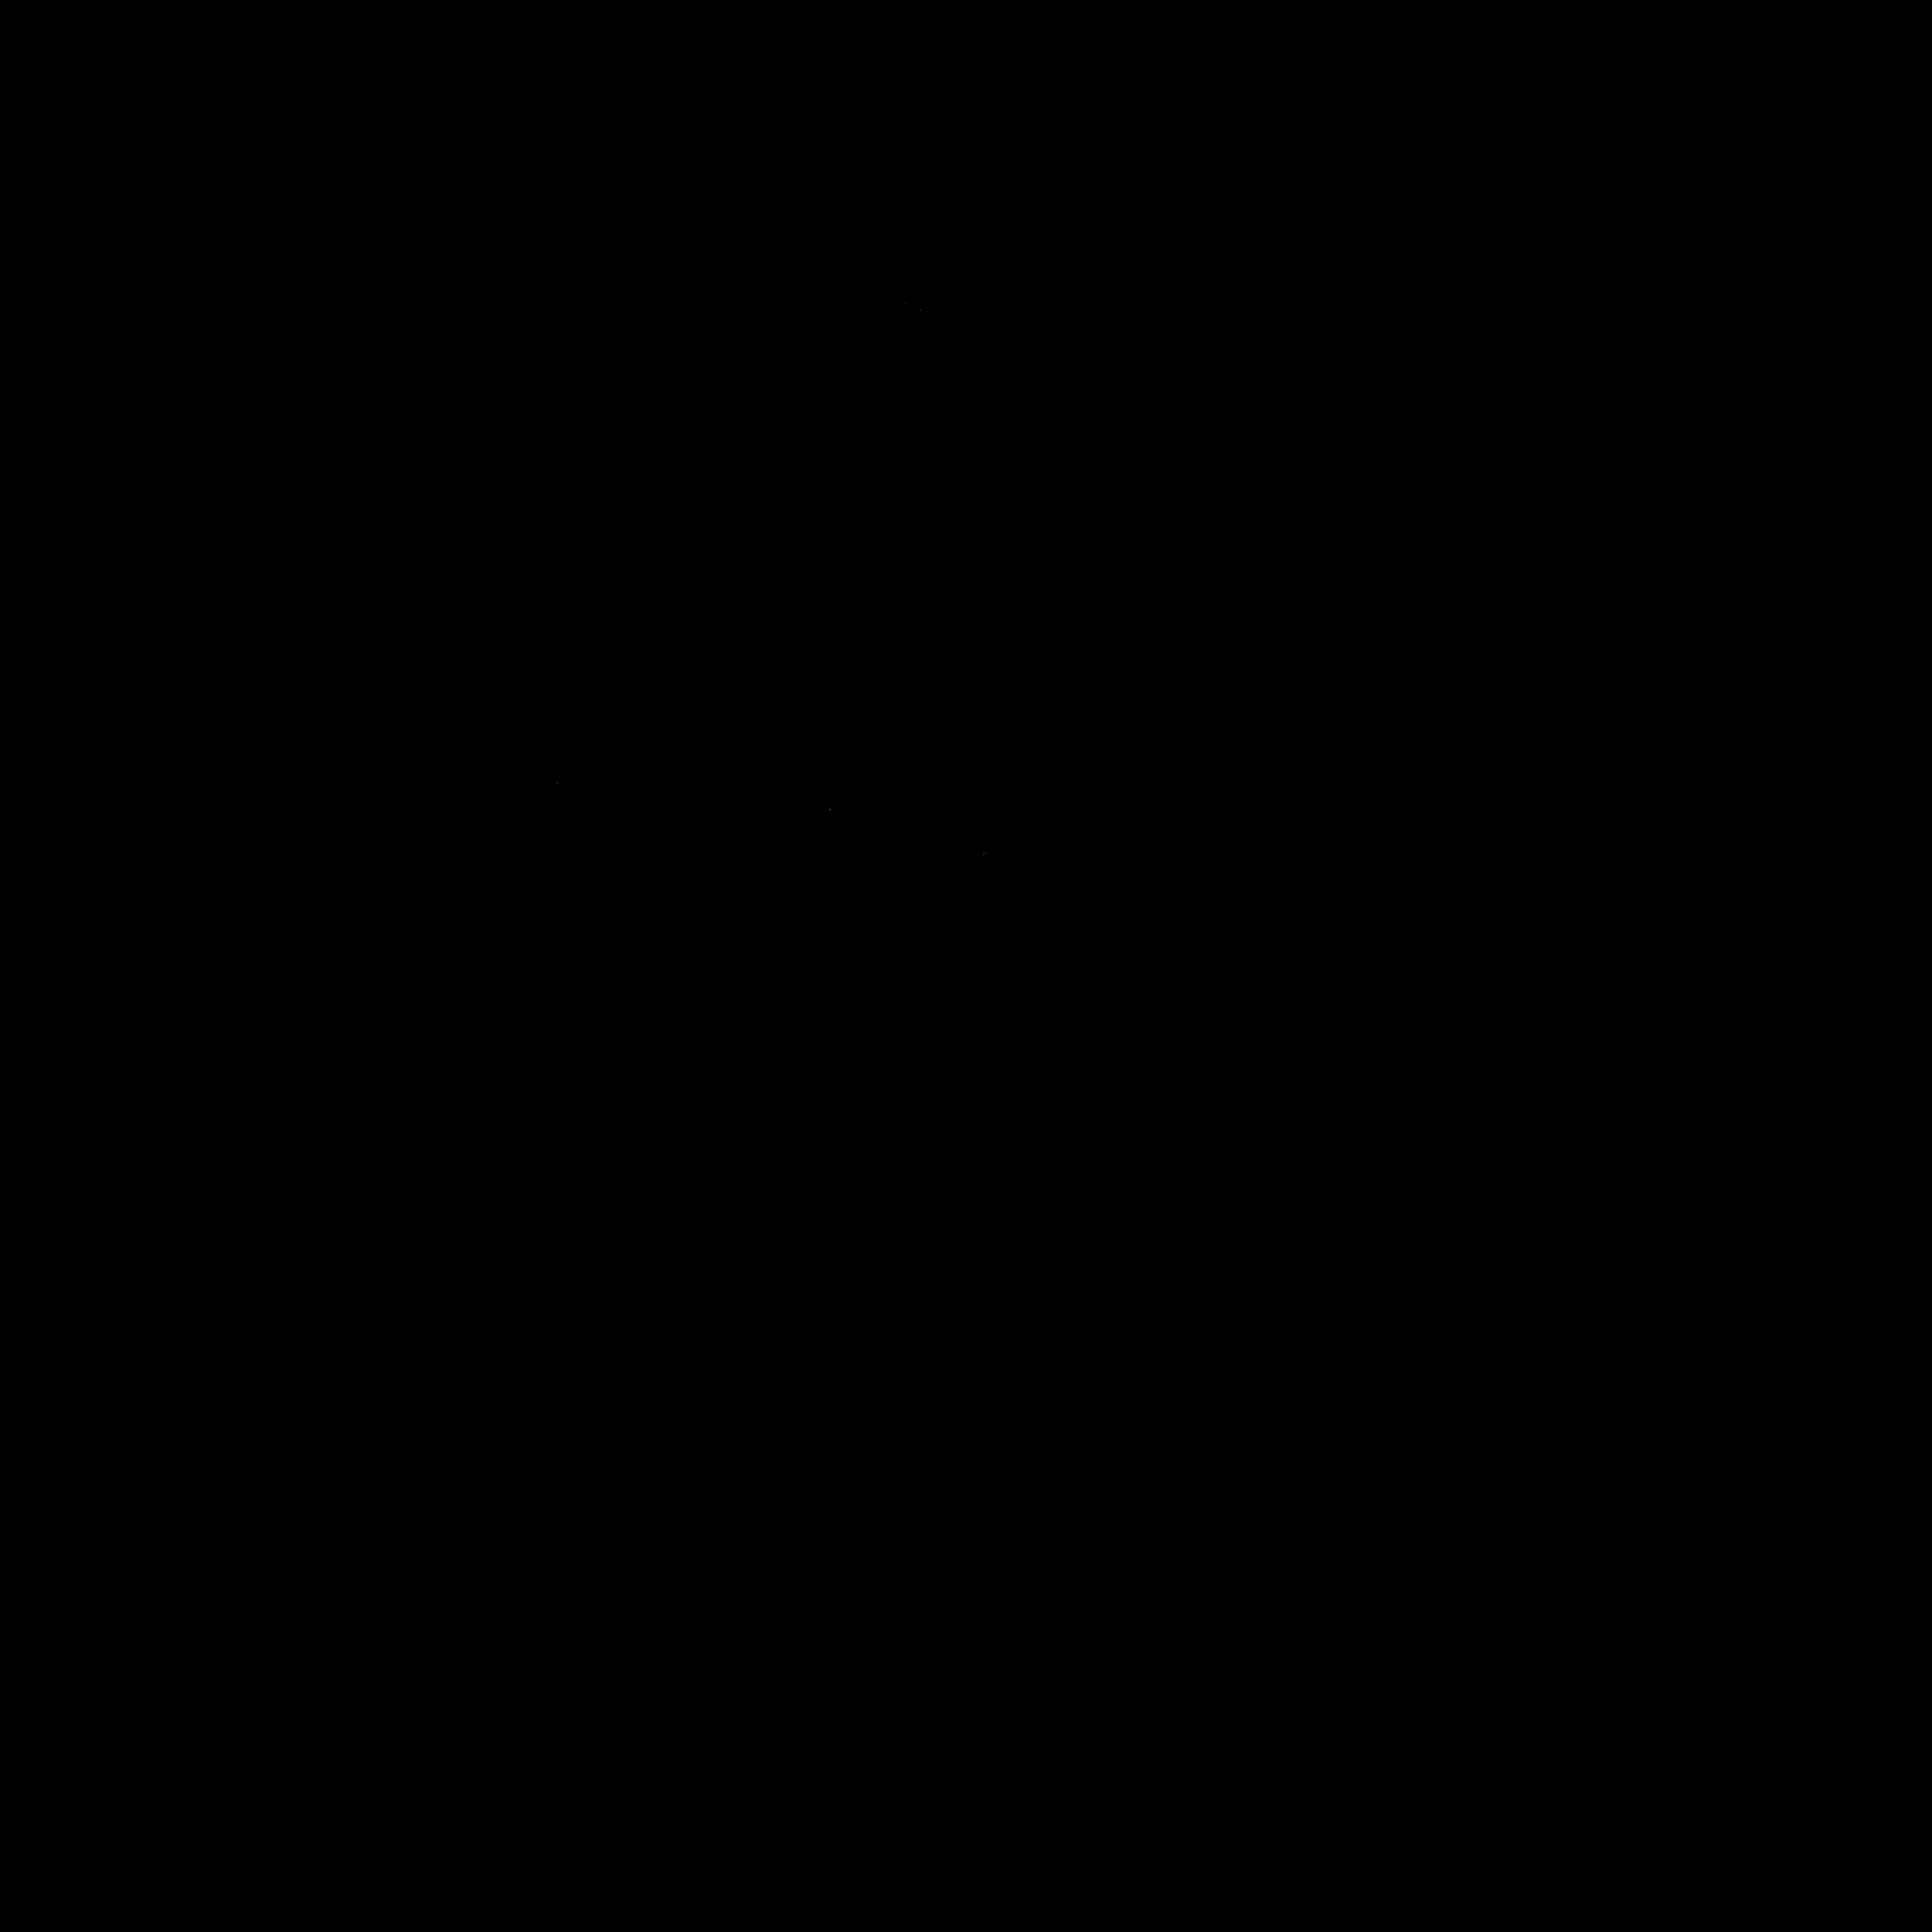

In [ ]:
seg_edge = np.zeros((4016, 4016))
corners = find_corners(contours_simplifier(contours[2].copy()))
simple = contours_simplifier(contours[2].copy())
x_coords = [simple[x][0] for x in corners]
y_coords = [simple[x][1] for x in corners]
print(x_coords)
print(y_coords)
seg_edge[x_coords, y_coords] = 255
cv2_imshow(seg_edge)

2 3
1.4370535350921776
(290, 410, 60, 140)
1 2


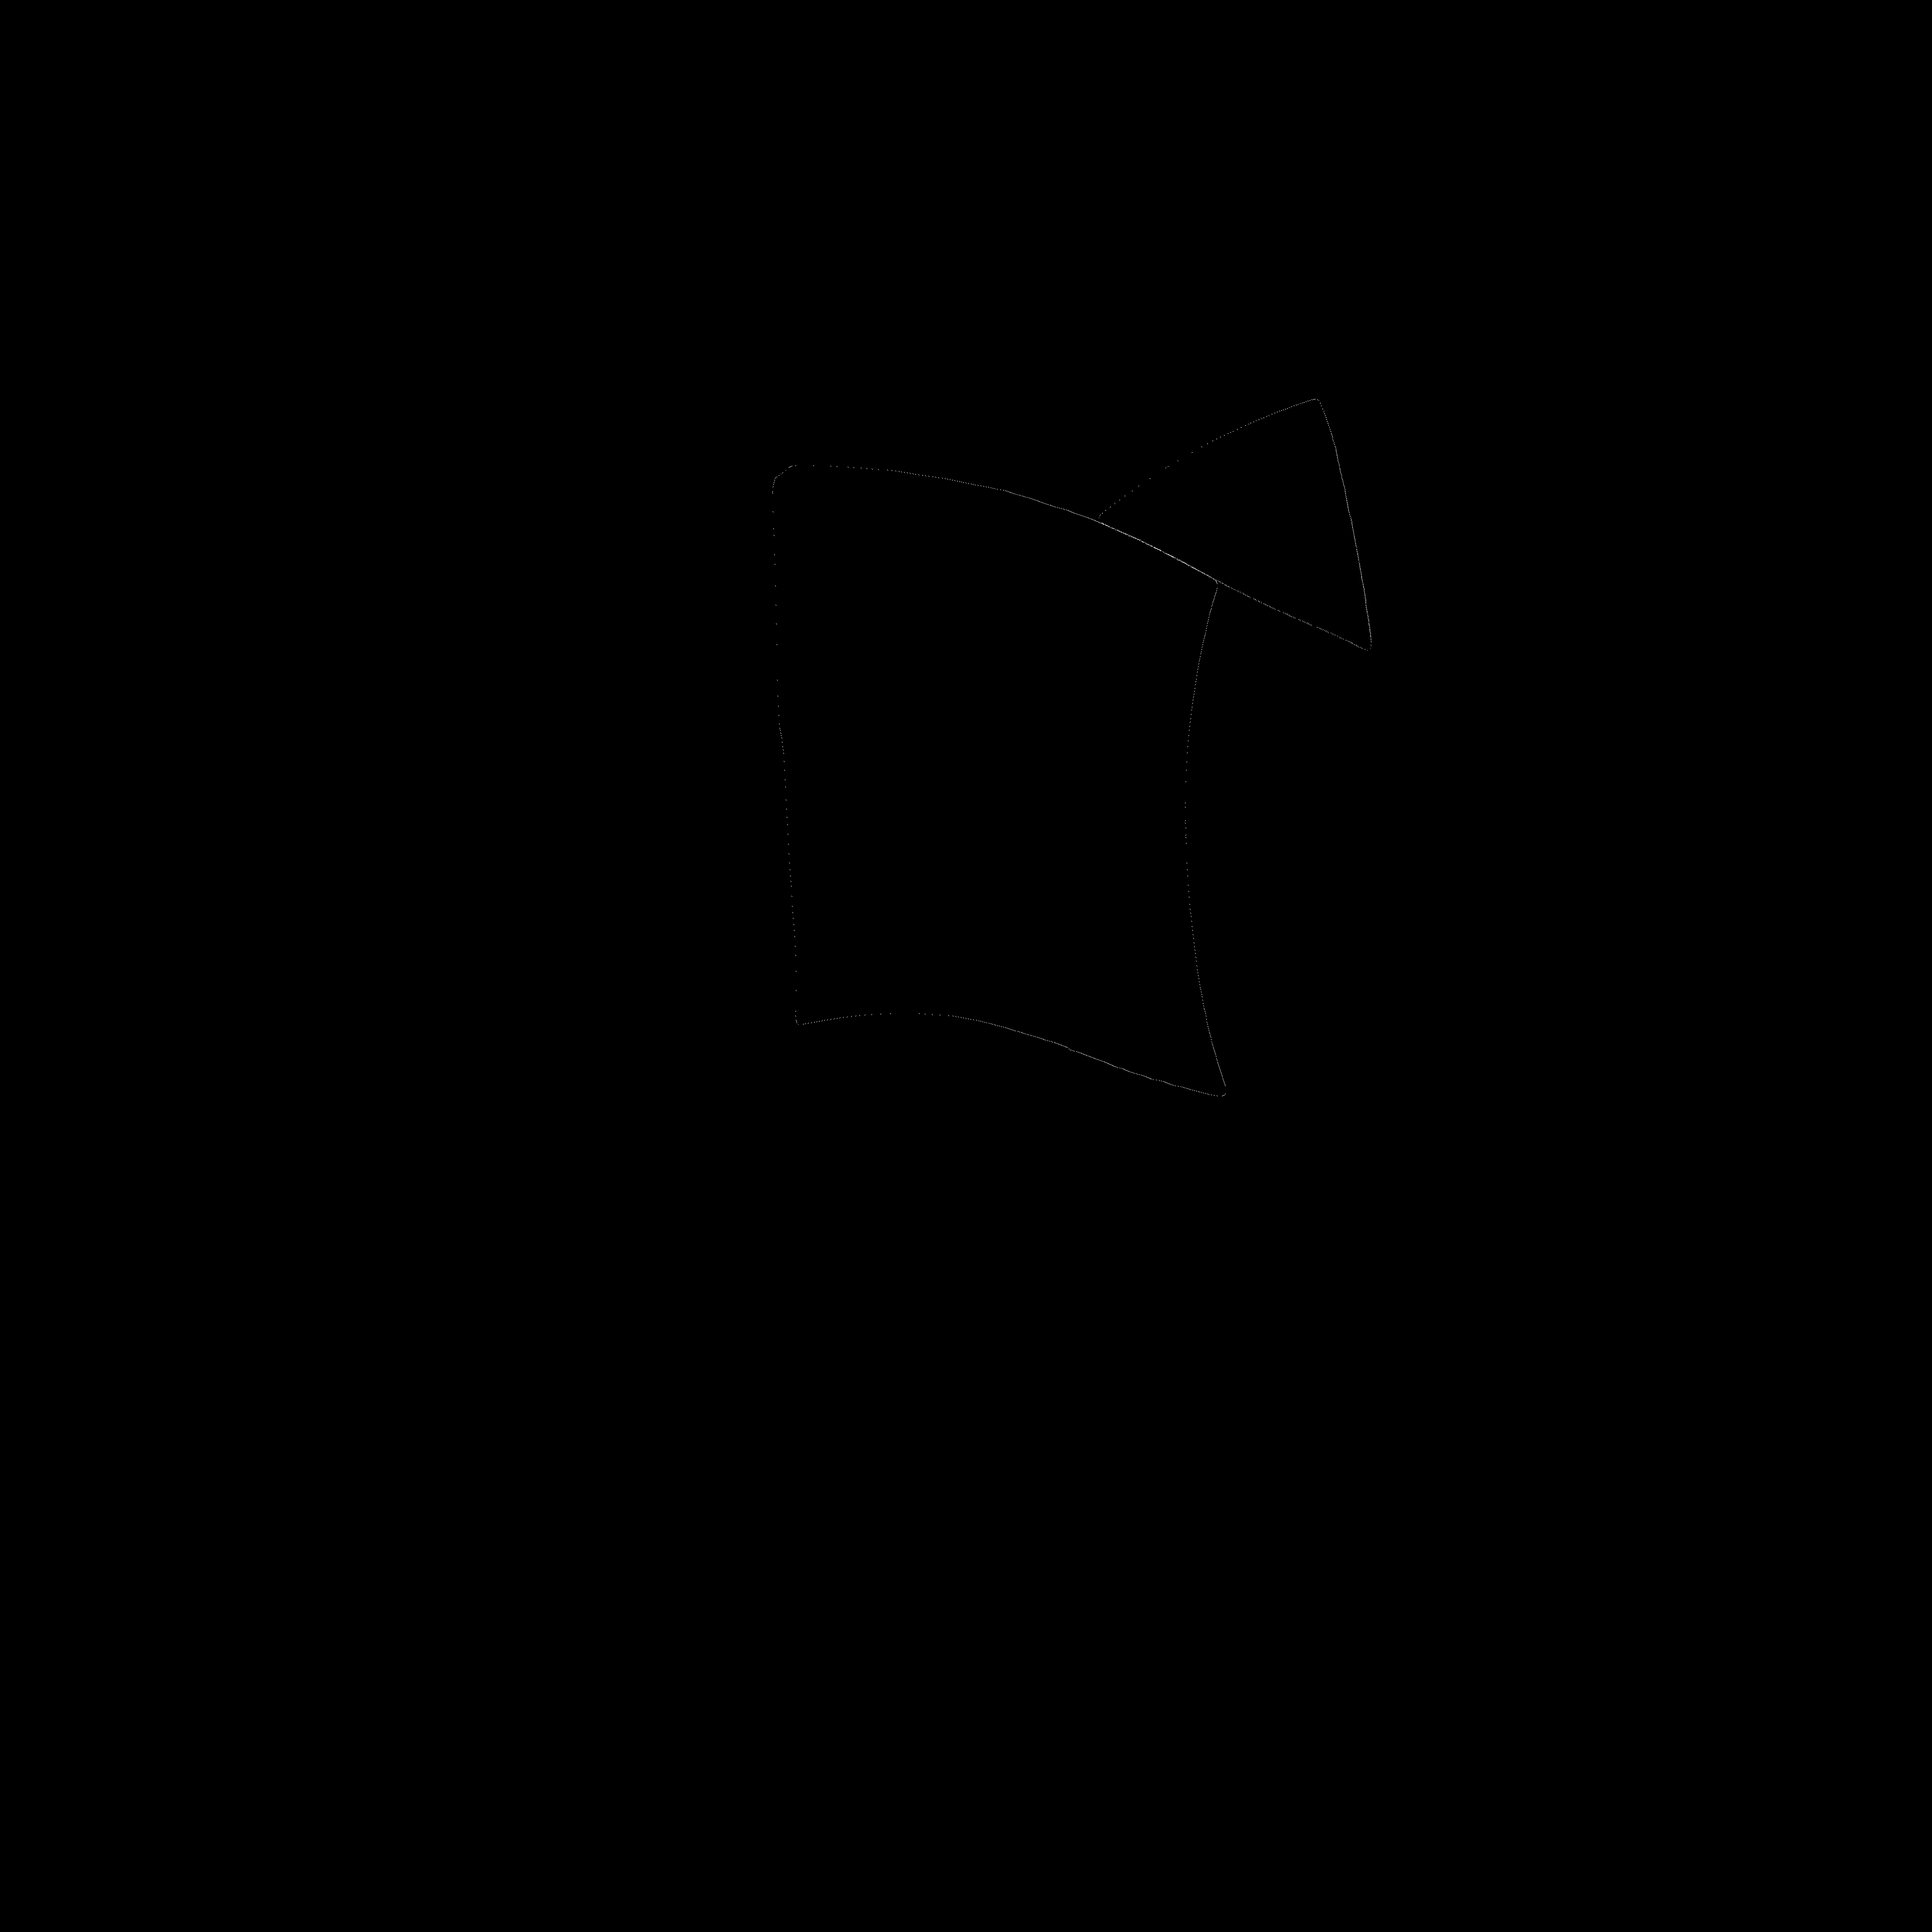

In [ ]:
def test_multiple_match():
  min_distance = 100
  bestX, bestY = -1, -1
  for x in range(3):
    #output.clear()
    #print(f"{(x*100)/6}%")
    for y in range(x + 1, 4):
      output.clear()
      print(x, y)
      score, coords = new_match_for_multi(contours[x], contours[y], min_distance)
      if score < min_distance:
        min_distance = score
        min_coords = coords
        bestX = x
        bestY = y

  #TODO creazione del nuovo pezzo definito dal marge del match migliore e reiterare il metodo sostituendo i 2 pezzi "vincitori"
  #col loro merge
  print(min_distance)
  print(min_coords)
  print(bestX, bestY)
  merge_visualize(bestX, bestY, min_coords)

test_multiple_match()

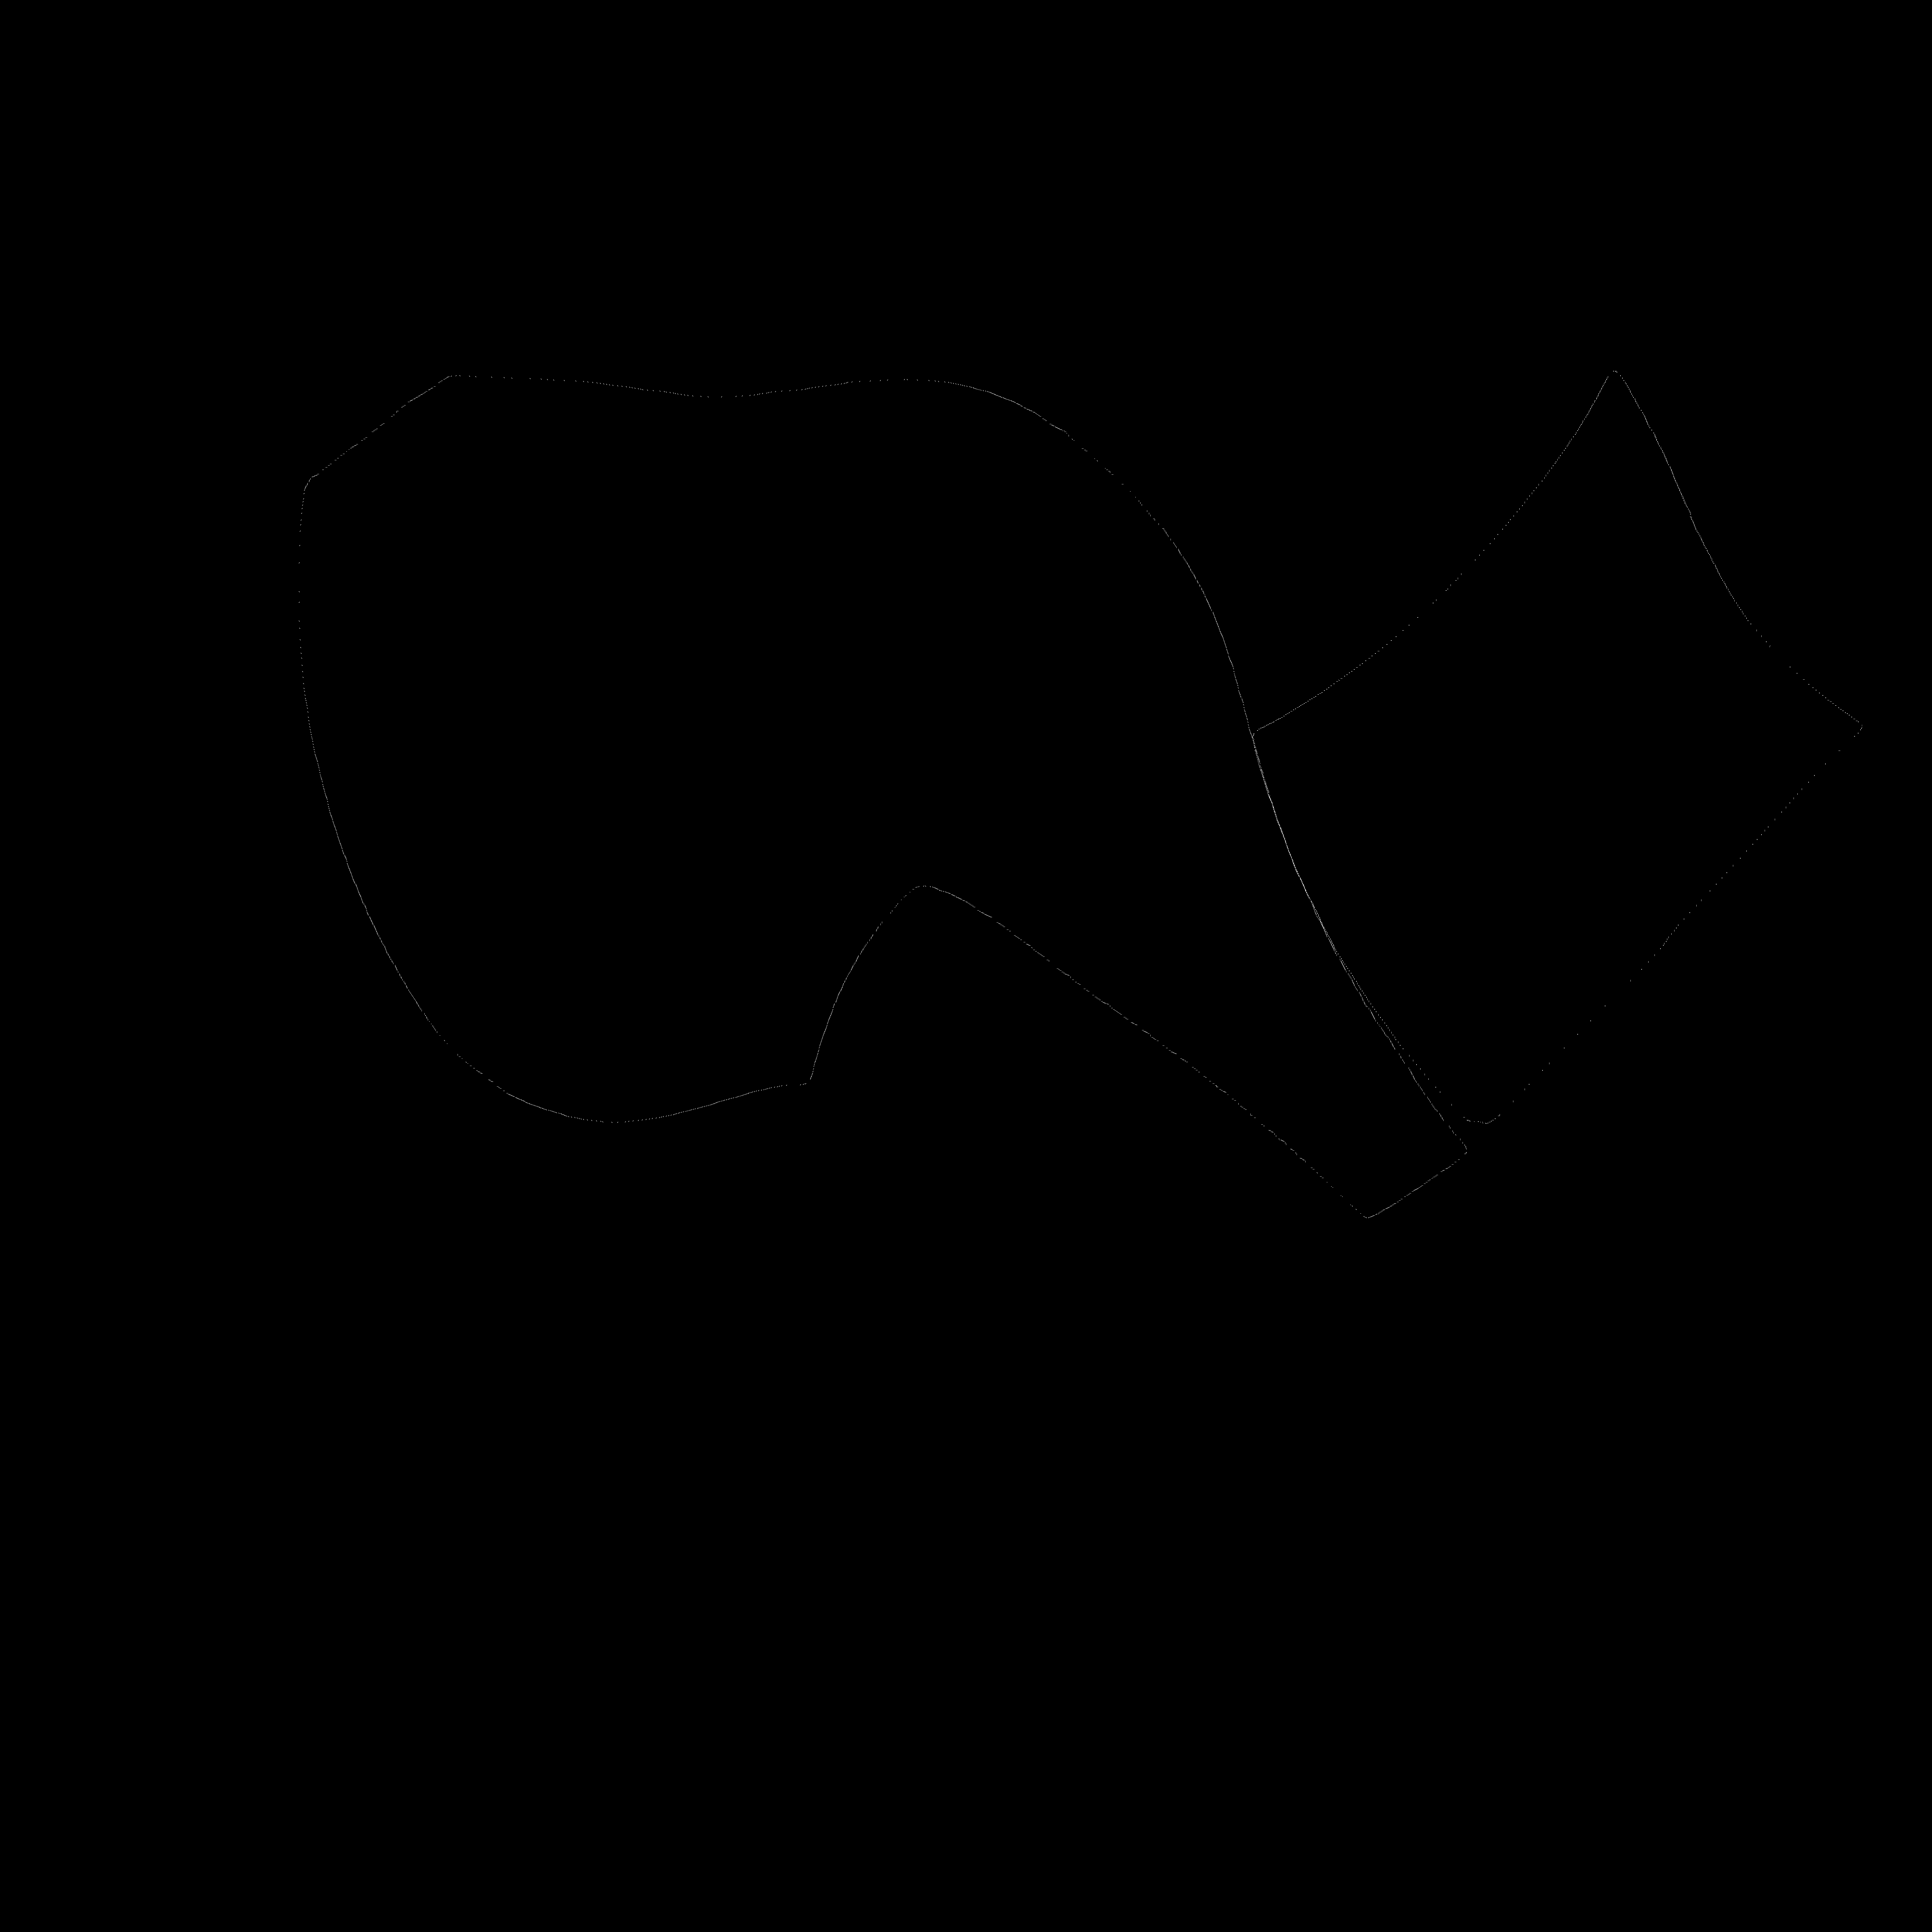

In [ ]:
#ATTACCA I PEZZI
edge_1 = contours_simplifier(contours[0].copy())
edge_2 = contours_simplifier(contours[1].copy())
edge_min = min((edge_1, edge_2), key=len)
edge_min = edge_min[::-1]
edge_max = max((edge_1, edge_2), key=len)

shift = edge_max[coords[0]:coords[1]][0] - edge_min[coords[2]:coords[3]][0]
edge_min += shift

angle_prova = get_angle(edge_max[coords[0]:coords[1]][-1], edge_max[coords[0]:coords[1]][0], edge_min[coords[2]:coords[3]][-1])
edge_min = rotate(edge_min, edge_min[coords[2]:coords[3]][0], angle_prova)
edge_min = np.ceil(edge_min).astype(int)

while(get_cosine_angle(edge_max[coords[0]:coords[1]][-1], edge_max[coords[0]:coords[1]][0], edge_min[coords[2]:coords[3]][-1]) < 0.90):
  angle_prova = get_angle(edge_max[coords[0]:coords[1]][-1], edge_max[coords[0]:coords[1]][0], edge_min[coords[2]:coords[3]][-1])
  edge_min = rotate(edge_min, edge_min[coords[2]:coords[3]][0], angle_prova)
  edge_min = np.ceil(edge_min).astype(int)

joined_coords = np.concatenate((edge_max, edge_min))

seg_edge = np.zeros((4016, 4016))
joined_coords += 500
x_coords, y_coords = joined_coords[:, 0], joined_coords[:, 1]
seg_edge[x_coords, y_coords] = 255
cv2_imshow(seg_edge)

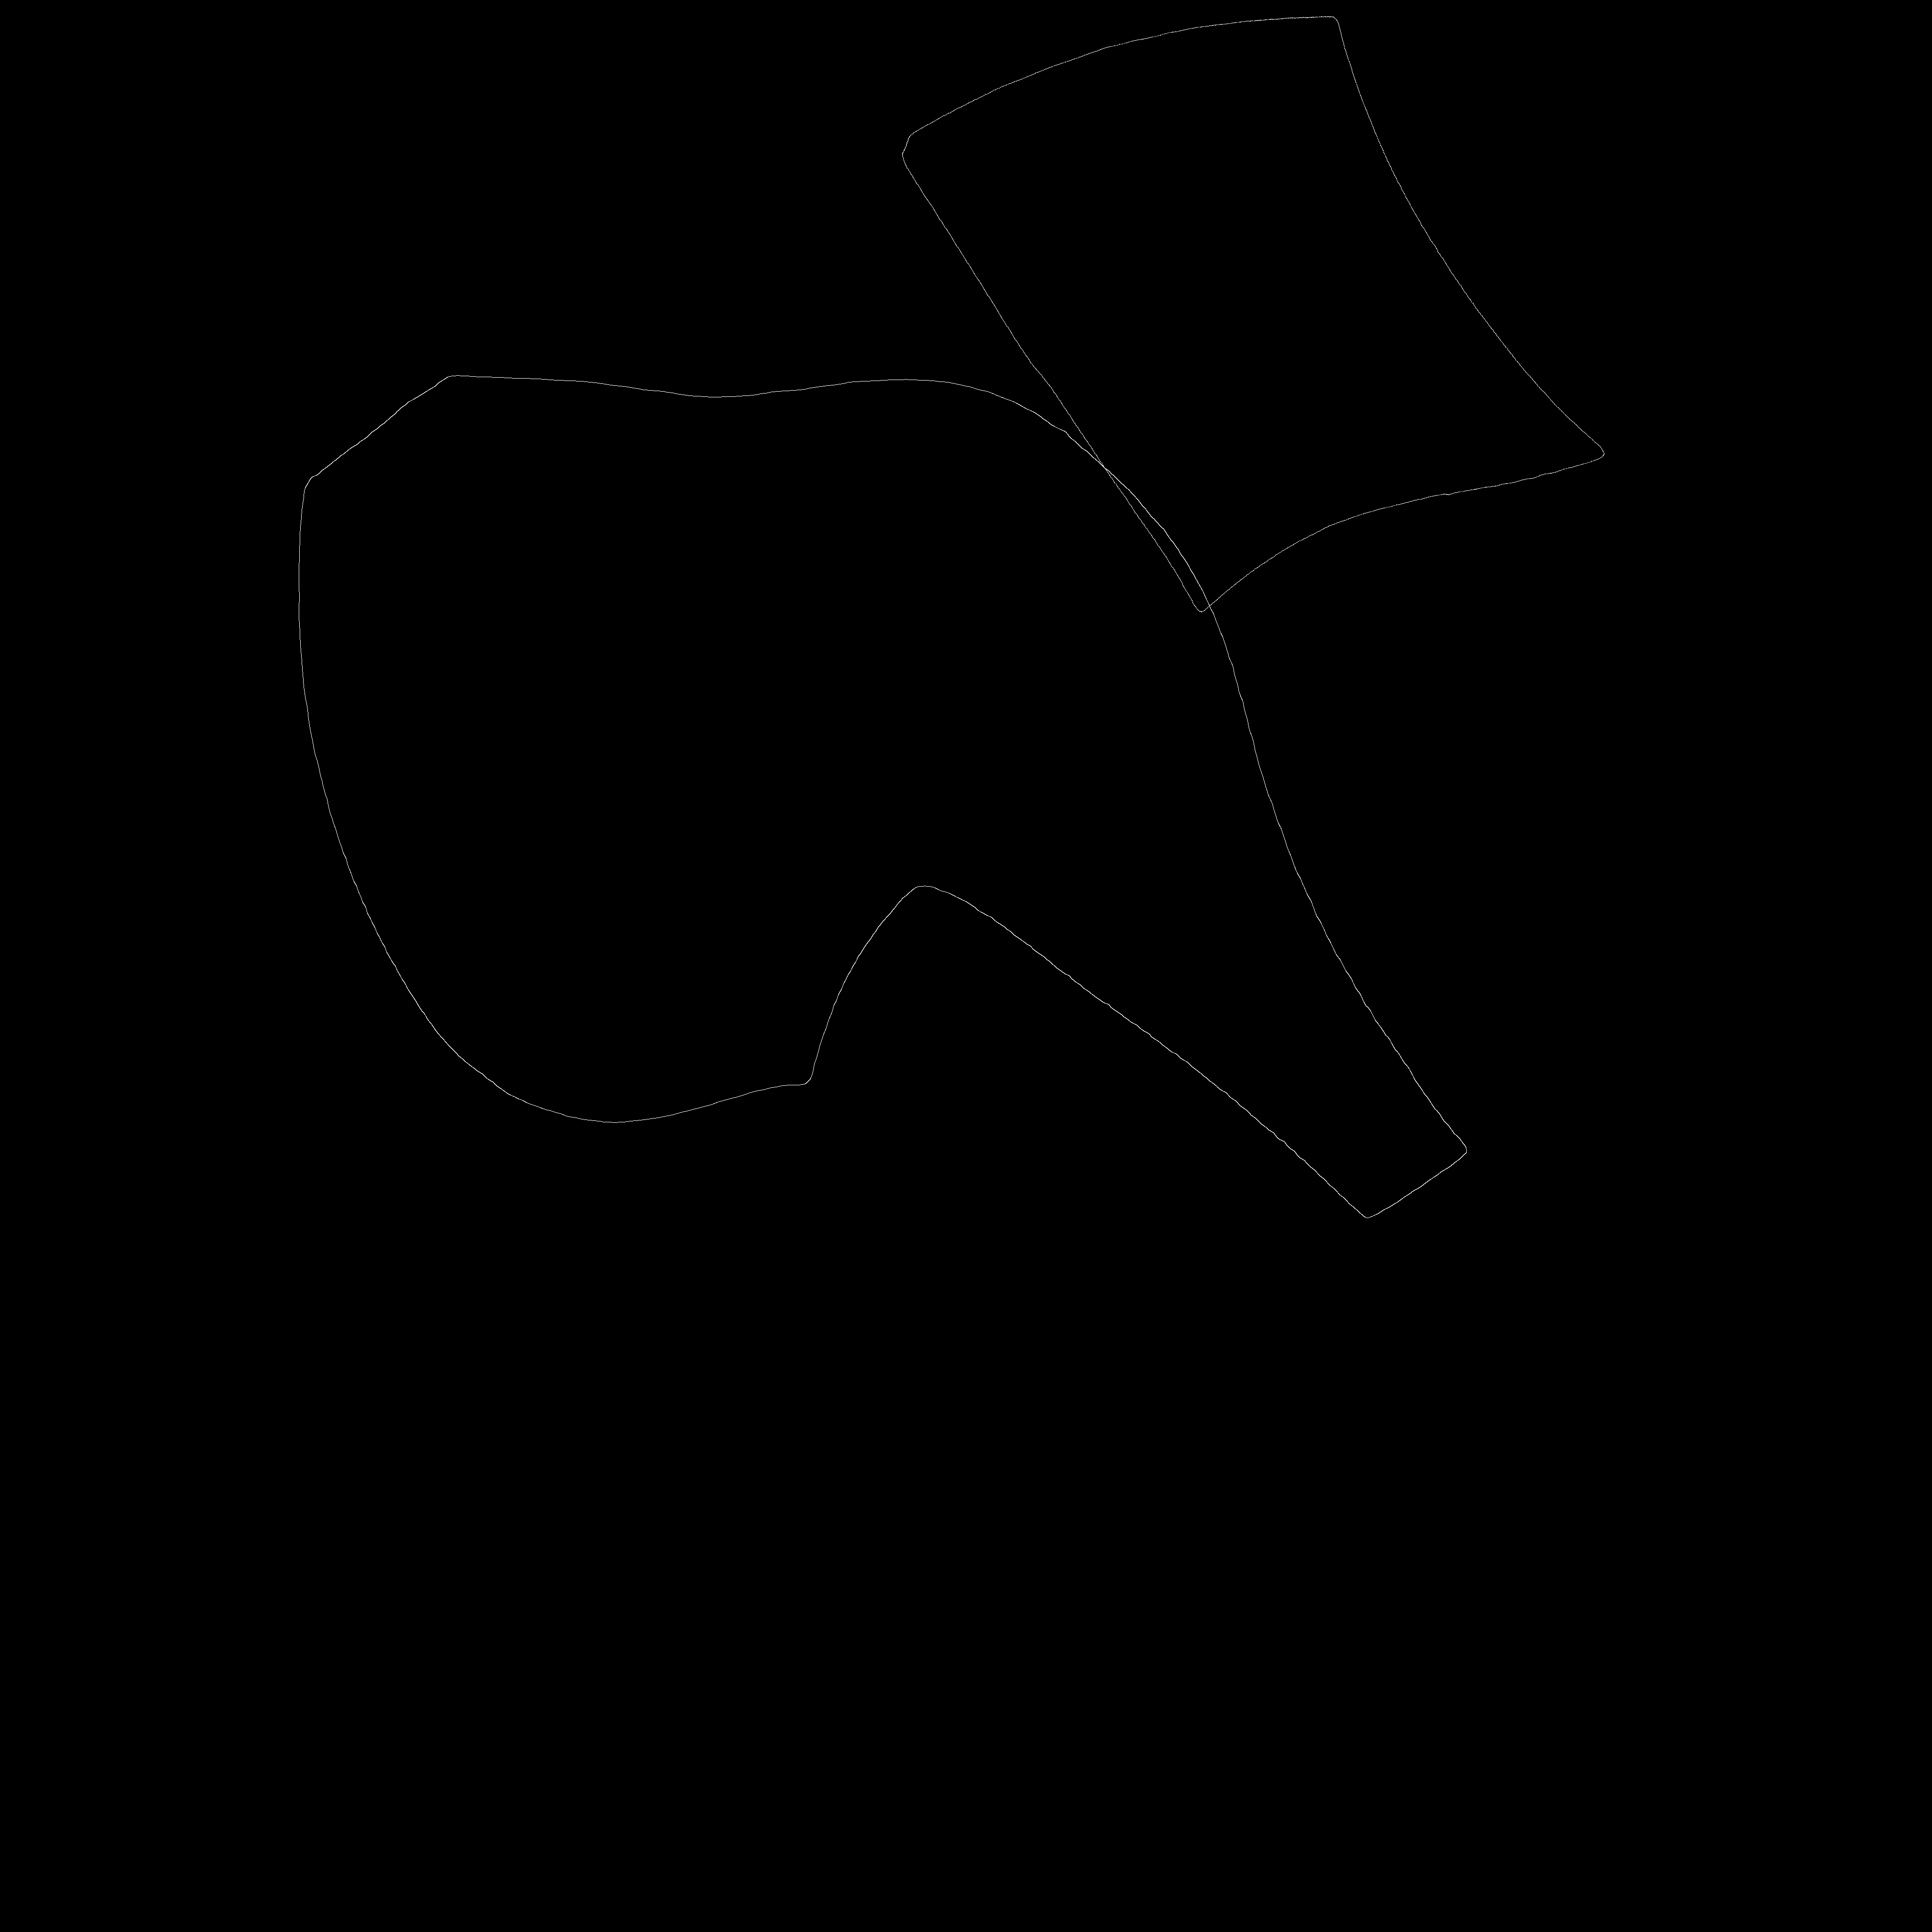

In [ ]:
#ATTACCA I PEZZI
edge_1 = contours[0].copy()
edge_2 = contours[1].copy()
edge_min = min((edge_1, edge_2), key=len)
edge_min = edge_min[::-1]
edge_max = max((edge_1, edge_2), key=len)

shift = edge_max[coords[0]:coords[1]][0] - edge_min[coords[2]:coords[3]][0]
edge_min += shift

angle_prova = get_angle(edge_max[coords[0]:coords[1]][-1], edge_max[coords[0]:coords[1]][0], edge_min[coords[2]:coords[3]][-1])
edge_min = rotate(edge_min, edge_min[coords[2]:coords[3]][0], angle_prova)
edge_min = np.ceil(edge_min).astype(int)

while(get_cosine_angle(edge_max[coords[0]:coords[1]][-1], edge_max[coords[0]:coords[1]][0], edge_min[coords[2]:coords[3]][-1]) < 0.90):
  angle_prova = get_angle(edge_max[coords[0]:coords[1]][-1], edge_max[coords[0]:coords[1]][0], edge_min[coords[2]:coords[3]][-1])
  edge_min = rotate(edge_min, edge_min[coords[2]:coords[3]][0], angle_prova)
  edge_min = np.ceil(edge_min).astype(int)

joined_coords = np.concatenate((edge_max, edge_min))

seg_edge = np.zeros((4016, 4016))
joined_coords += 500
x_coords, y_coords = joined_coords[:, 0], joined_coords[:, 1]
seg_edge[x_coords, y_coords] = 255
cv2_imshow(seg_edge)

In [ ]:
visualize(coords, contours[0], contours[2])